In [1]:
# Create new multi-modal edges that link road, rail and maritime network interchange nodes
# Combine networks into one, with unified schema
# Add destination country nodes 
# Duplicate, reverse and append all intermodal, road and rail edges (to match maritime)

In [2]:
import os

import geopandas as gpd
import igraph as ig
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import pyproj
from scipy.spatial import cKDTree
from shapely.geometry import LineString, Point
from shapely.ops import linemerge
from tqdm import tqdm

plt.style.use("dark_background")

In [3]:
def duplicate_reverse_and_append_edges(edges: pd.DataFrame) -> pd.DataFrame:
    """
    Given edges with `from_id`, `to_id`, `from_iso_a3` and `to_iso_a3` columns,
    create duplicate edges with direction reversed.

    Args:
        edges: Table of edges to reverse and append to

    Returns:
        Table consisting of original edges and their reversed duplicates.
    """
    reversed_edges = edges.copy()
    reversed_edges.from_id = edges.to_id
    reversed_edges.to_id = edges.from_id
    reversed_edges.from_iso_a3 = edges.to_iso_a3
    reversed_edges.to_iso_a3 = edges.from_iso_a3
    return pd.concat([edges, reversed_edges])

In [4]:
def preprocess_road_rail_network(
    nodes_path: str,
    edges_path: str,
    mode: str,
    cost_USD_t_km: float,
    directional: float
) -> tuple[gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Preprocess road or rail network data into a suitable format for multi-modal routing.
    Find length of edges, calculate cost. Relabel IDs to include mode so they're unique across networks.
    
    Args:
        nodes_path: Path to nodes geoparquet file on disk
        edges_path: Path to edges geoparquet file on disk
        mode: Transport mode categorical string to store under edges["mode"]
        cost_USD_t_km: Cost of transporting goods in USD per tonne km
        directional: Whether to duplicate, reverse and append edges (from_id and to_id switched)

    Returns:
        Nodes and edges as two GeoDataFrames.
    """

    edges = gpd.read_parquet(edges_path)
    edges["mode"] = mode
    edges["cost_USD_t_km"] = cost_USD_t_km
    edges["distance_km"] = edges.geometry.to_crs(edges.estimate_utm_crs()).length / 1_000
    edges["cost_USD_t"] = edges["cost_USD_t_km"] * edges["distance_km"]
    edges["id"] = edges.apply(lambda row: f"{row['mode']}_{row['id']}", axis=1)
    edges["to_id"] = edges.apply(lambda row: f"{row['mode']}_{row['to_id']}", axis=1)
    edges["from_id"] = edges.apply(lambda row: f"{row['mode']}_{row['from_id']}", axis=1)

    if directional:
        edges = duplicate_reverse_and_append_edges(edges)
    
    nodes = gpd.read_parquet(nodes_path)
    nodes["mode"] = mode
    nodes["id"] = nodes.apply(lambda row: f"{row['mode']}_{row['id']}", axis=1)

    return nodes, edges

In [5]:
def preprocess_maritime_network(nodes_path: str, edges_path: str) -> tuple[gpd.GeoDataFrame, pd.DataFrame]:
    """
    Preprocess maritime network data into a suitable format for multi-modal routing.
    Relabel IDs so they're unique across networks.
    
    Args:
        nodes_path: Path to nodes geoparquet file on disk
        edges_path: Path to edges parquet file on disk

    Returns:
        Nodes GeoDataFrame and edges DataFrame.
    """
    edges = pd.read_parquet(edges_path).rename(columns={"from_iso3": "from_iso_a3", "to_iso3": "to_iso_a3"})
    edges["mode"] = "maritime"
    edges["cost_USD_t"] = edges["distance_km"] * edges["cost_USD_t_km"]
    
    nodes = gpd.read_parquet(nodes_path)
    nodes = nodes.rename(columns={"iso3": "iso_a3"})
    nodes = nodes.drop(columns=["Continent_Code"])
    ports_mask = nodes.infra == "port"

    # we want to connect our road and rail nodes to the port_land node of the port_in, port_out, port_land trifecta
    nodes.loc[ports_mask, "id"] = nodes.loc[ports_mask, :].apply(lambda row: f"{row.id}_land", axis=1)

    return nodes, edges

In [6]:
def find_nearest_points(
    a: gpd.GeoDataFrame,
    b: gpd.GeoDataFrame,
    b_id_col: str,
) -> gpd.GeoDataFrame:
    """
    Given two GeoDataFrames of point locations, `a` and `b`, for each point in `a`, find the closest in `b`.

    Modified from:
    https://gis.stackexchange.com/questions/222315/finding-nearest-point-in-other-geodataframe-using-geopandas

    a: Table of points to start from, we run over every row here
    b: Table of candidate closest points
    b_id_col: Name of column in b identifying points

    Returns:
        `a`, joined with the values from `b_id_col` from the points of `b` which are closest
    """

    # find nearest point in b for each and every point in a
    tree = cKDTree(b.geometry.get_coordinates().to_numpy())
    distances, indicies = tree.query(a.geometry.get_coordinates().to_numpy(), k=1)
    nearest_points = b.iloc[indicies][[b_id_col, "geometry"]] \
        .reset_index(drop=True).rename(columns={"geometry": "nearest_node_geometry"})
    
    return pd.concat(
        [
            a.reset_index(drop=True),
            nearest_points,
            pd.Series(data=distances, name='distance')
        ], 
        axis=1
    )

In [7]:
def create_edges_to_nearest_nodes(
    a: gpd.GeoDataFrame,
    b: gpd.GeoDataFrame,
    max_distance_m: float,
    projected_coordinate_system: pyproj.crs.crs.CRS,
) -> gpd.GeoDataFrame:
    """
    Given two sets of nodes, a and b, loop through nodes in a, finding the closest 
    node in b (which is less than `max_distance_m` away). Create a linear linestring
    connecting these points.

    Args:
        a: Table of nodes to connect from, containing GeoSeries of point locations.
            Must contain "id", "iso_a3" and "geometry" columns.
        b: Table of candidate notes to connect to, containing Geoseries of point locations.
            Must contain "id" and "geometry" columns.
        max_distance_m: Edges only created if their span in metres is equal to or less than this value.
        projected_coordinate_system: Project points to this CRS (must use metres!) before estimating distances.

    Returns:
        Table of linking edges.
    """
    
    point_pairs = find_nearest_points(
        a.to_crs(projected_coordinate_system),
        b.to_crs(projected_coordinate_system).rename(columns={"id": "nearest_node_id"}),
        "nearest_node_id"
    ).rename(columns={"distance": "distance_m"})

    point_pairs = point_pairs[point_pairs.distance_m < max_distance_m]

    edges = point_pairs.apply(
        lambda row: {
            "from_id": row.id,
            "to_id": row.nearest_node_id,
            "from_iso_a3": row.iso_a3,
            "to_iso_a3": row.iso_a3,  # assume link does not cross a border
            "geometry": LineString([row.geometry, row.nearest_node_geometry]),
            "distance_m": row.distance_m
        },
        axis=1,
        result_type="expand"
    )
    
    return gpd.GeoDataFrame(edges).reset_index(drop=True).set_crs(projected_coordinate_system)

In [8]:
def find_importing_node_id(row: pd.Series, exporting_country: str) -> str:
    """
    Return the node id lying in the importing country

    Args:
        row: Table row with columns from_iso_a3, to_iso_a3, from_id and to_id
        exporting_country: ISO A3 code of exporting country

    Returns
        node id
    """
    if row.from_iso_a3 == exporting_country and row.to_iso_a3 != exporting_country:
        return row.to_id
    elif row.from_iso_a3 != exporting_country and row.to_iso_a3 == exporting_country:
        return row.from_id
    else:
        raise RuntimeError

In [9]:
def create_edges_to_destination_countries(
    origin_nodes: gpd.GeoDataFrame,
    destination_country_nodes: gpd.GeoDataFrame,
    cost_USD_t: float = 1E6,
) -> gpd.GeoDataFrame:
    """
    Create edges between nodes within the same country of zero cost.

    Args:
        origin_nodes: Table of origin nodes to create edges from
        destination_country_nodes: Table of destination nodes to connect to, one per country
        cost_USD_t: Cost of traversing this edge, in USD per tonne. Defaults to a very high 
            value, so that route allocations will only use these edges as a final connection 
            to the destination, rather than a general means of traversal. 

    Returns:
        Table of edges of same length as origin_nodes, connecting these to destination_country_nodes
    """

    assert len(destination_country_nodes.iso_a3) == len(destination_country_nodes.iso_a3.unique())
    assert origin_nodes.crs == destination_country_nodes.crs

    def make_edge(row: pd.Series) -> dict:
        destination = destination_country_nodes.set_index("iso_a3").loc[row.iso_a3]
        return {
            "from_id": row.id,
            "to_id": destination.id,
            "from_iso_a3": row.iso_a3,
            "to_iso_a3": row.iso_a3,
            "mode": "imaginary",
            "geometry": LineString(
                [
                    row.geometry,
                    destination.geometry
                ]
            ),
            "cost_USD_t": cost_USD_t
        }

    edges = origin_nodes.apply(
        make_edge,
        axis=1,
        result_type="expand"
    )
    
    return gpd.GeoDataFrame(edges).reset_index(drop=True).set_crs(origin_nodes.crs)

In [10]:
def path_edges_from_ordered_id_list(path_node_ids: list[str], edges: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    If `path_node_ids` are sequential nodes forming a path through a graph made of `edges`,
    return the subset of ordered edges connecting these nodes.

    Args:
        path_node_ids: Sequential node ids of some path through graph
        edges: Set of edges containing possible path edges

    Returns:
        Ordered subset of `edges` corresponding to path prescribed by `path_node_ids`
    """
    route_edges = []
    for i, from_node_id in enumerate(path_node_ids[:-1]):
        to_node_id = path_node_ids[i + 1]
        edge = edges[(edges.from_id == from_node_id) & (edges.to_id == to_node_id)]
        assert len(edge) == 1
        route_edges.append(edge)
    return pd.concat(route_edges)

In [11]:
# read network data from disk and preprocess

study_country = "THA"
root_dir = ".."

road_nodes, road_edges = preprocess_road_rail_network(
    os.path.join(root_dir, "results/composite_network/south-east-asia-road/nodes.gpq"),
    os.path.join(root_dir, "results/composite_network/south-east-asia-road/edges.gpq"),
    "road",
    0.1,  # 0.03 - 0.35 USD / (t km) a plausible range
    True
)

rail_nodes, rail_edges = preprocess_road_rail_network(
    os.path.join(root_dir, "results/composite_network/south-east-asia-rail/nodes.gpq"),
    os.path.join(root_dir, "results/composite_network/south-east-asia-rail/edges.gpq"),
    "rail",
    0.06, # 0.03 - 0.12 USD / (t km) a plausible range
    True
)

# possible cargo types = ("container", "dry_bulk", "general_cargo",  "roro", "tanker")
# for now, just use 'general_cargo'
maritime_nodes, maritime_edges_no_geom = preprocess_maritime_network(
    os.path.join(root_dir, "results/input/maritime/nodes.gpq"),
    os.path.join(root_dir, "results/input/maritime/edges_by_cargo/maritime_base_network_general_cargo.pq")
)

# put Bangkok port in the right place...
maritime_nodes.loc[maritime_nodes.name == "Bangkok_Thailand", "geometry"] = Point((100.5753, 13.7037))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77862/77862 [02:48<00:00, 461.72it/s]


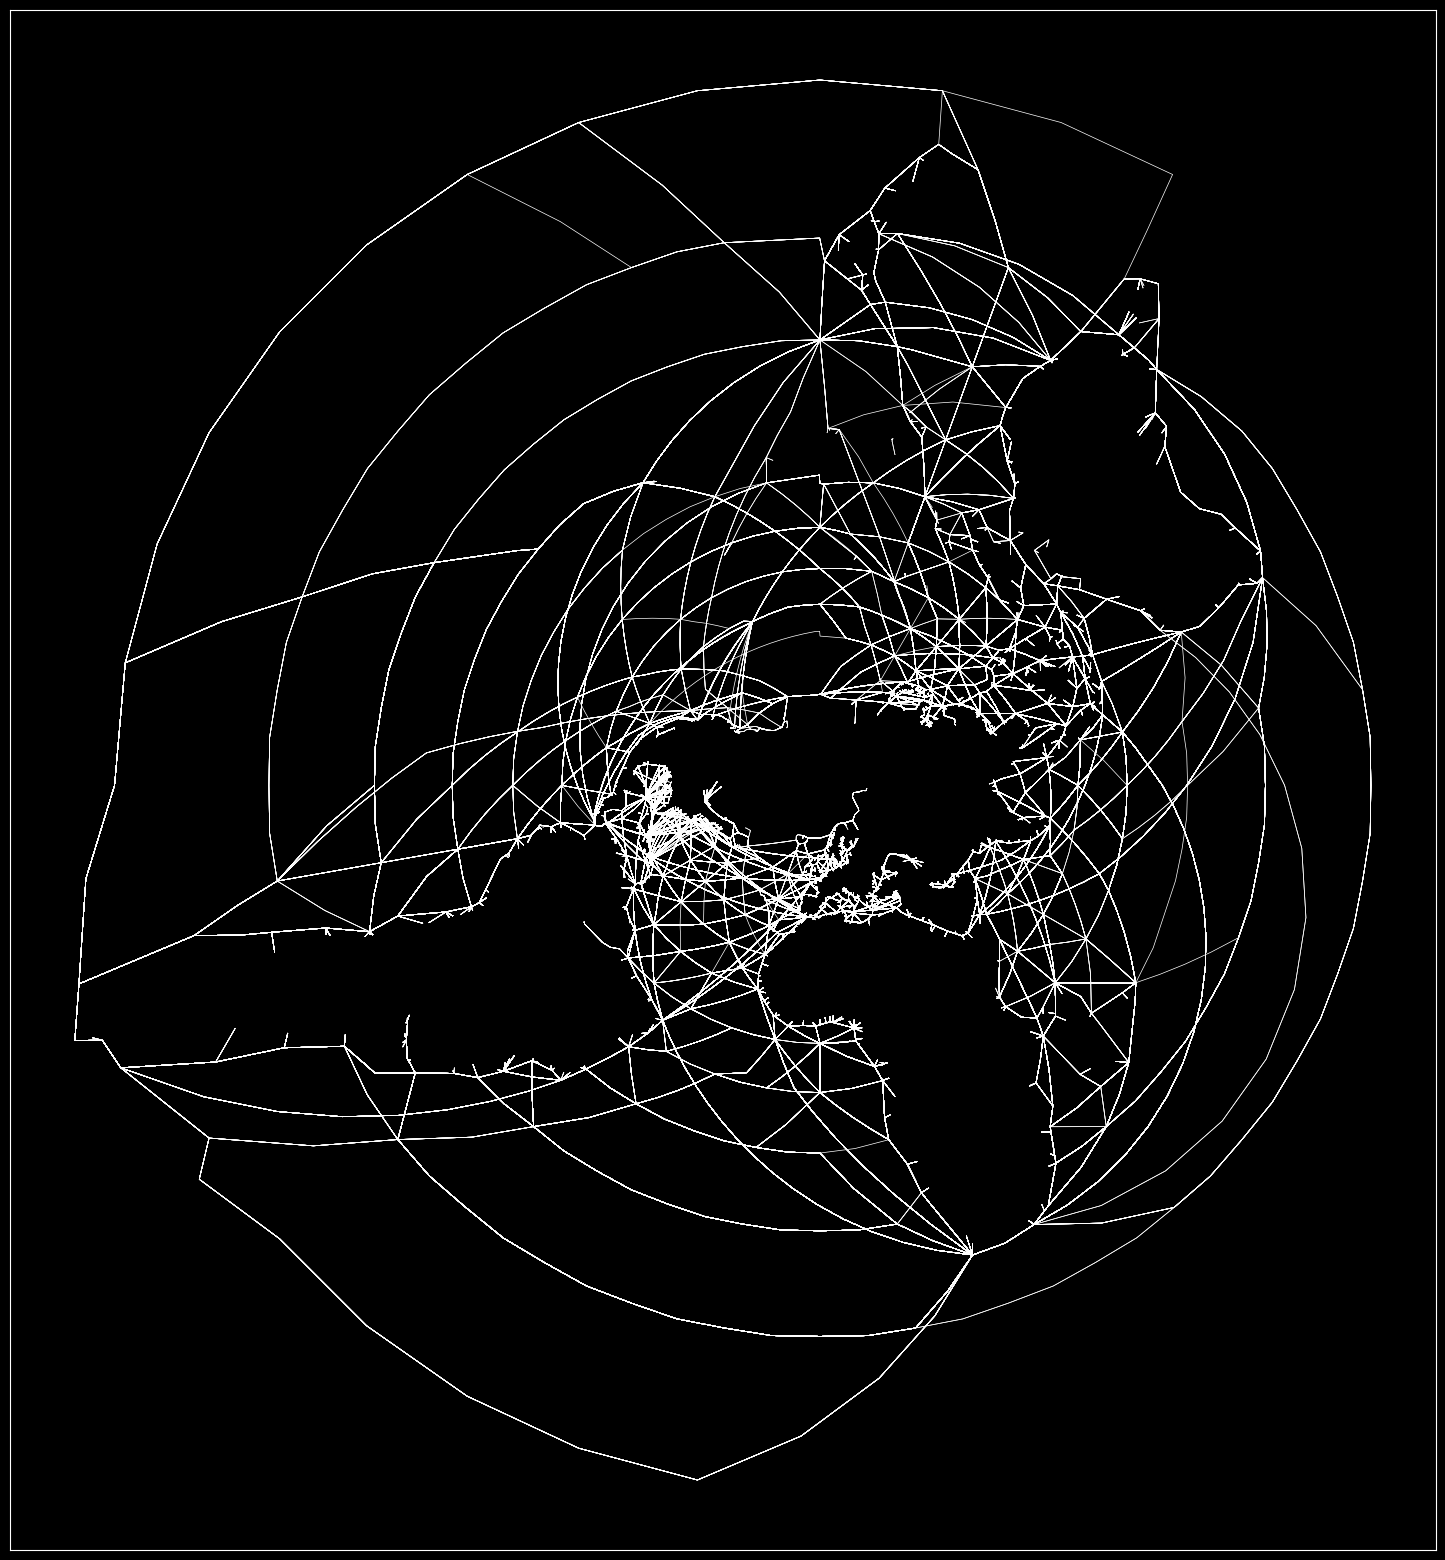

In [12]:
# Jasper's maritime edges in 'edges_by_cargo' do not contain geometry
# this is because the AIS data that they were derived from only contain origin and destination port, not route
# this is a pain for visualisation, so we will create a geometry for each from `maritime_vis_edges`

maritime_vis_edges = gpd.read_parquet(os.path.join(root_dir, "results/input/maritime/edges.gpq"))
vis_graph = ig.Graph.DataFrame(maritime_vis_edges, directed=True, use_vids=False)

maritime_edges = maritime_edges_no_geom.copy()
change_of_port_mask = maritime_edges_no_geom.from_port != maritime_edges_no_geom.to_port
port_pairs_to_generate_geom_for = maritime_edges_no_geom[change_of_port_mask]
for index, row in tqdm(port_pairs_to_generate_geom_for.iterrows(), total=len(port_pairs_to_generate_geom_for)):
    edge_list = vis_graph.get_shortest_path(row.from_port, row.to_port, weights="distance", output="epath") 
    route_edges = maritime_vis_edges.iloc[edge_list]
    route_linestring = linemerge(list(route_edges.geometry))
    maritime_edges.loc[index, "geometry"] = route_linestring

maritime_edges = gpd.GeoDataFrame(maritime_edges).set_crs(epsg=4326)
f, ax = plt.subplots(figsize=(20,20))
maritime_edges.to_crs(epsg=3995).plot(
    ax=ax,
    linewidth=0.5,
    alpha=1
)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
f.savefig("maritime_edges.png")

In [13]:
# disambiguate the global view and plot the routes from each port, one port at a time

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.geometry = world.geometry.boundary

os.makedirs("port_plots", exist_ok=True)
ports = maritime_edges.from_port.unique()
for port_id in tqdm(ports):
    try:
        filepath = f"port_plots/{port_id}.png"
        if not os.path.exists(filepath):
            f, ax = plt.subplots(figsize=(10,10))
            port = maritime_nodes[maritime_nodes.id == f"{port_id}_land"]
            maritime_edges[maritime_edges.from_port == port_id].to_crs(epsg=3995).plot(
                column="to_port",
                categorical=True,
                ax=ax
            )
            maritime_nodes[maritime_nodes.id == f"{port_id}_land"].to_crs(epsg=3995).plot(
                ax=ax,
                markersize=500,
                marker="*",
                facecolor="none",
                color="r"
            )
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            world.to_crs(epsg=3995).plot(ax=ax, linewidth=0.5, alpha=0.4)
            ax.set_xlim(xmin, xmax)
            ax.set_ylim(ymin, ymax)
            port_name, = port.name
            ax.set_title(f"{port_id} ({port_name.replace('_', ', ')}) estimated routes")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            f.savefig()
            plt.close(f)
    except Exception as error:
        plt.close(f)
        print(f"Failed to plot {port_id}, skipping...")
        continue

/tmp/ipykernel_1358239/4166474967.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
  0%|▏                                                                                                                                                       | 2/1329 [00:00<03:19,  6.65it/s]

Failed to plot port0, skipping...
Failed to plot port1001, skipping...


  0%|▍                                                                                                                                                       | 4/1329 [00:00<03:33,  6.22it/s]

Failed to plot port1005, skipping...
Failed to plot port103, skipping...


  0%|▋                                                                                                                                                       | 6/1329 [00:00<03:28,  6.35it/s]

Failed to plot port1059, skipping...
Failed to plot port1104, skipping...


  1%|▉                                                                                                                                                       | 8/1329 [00:01<03:41,  5.97it/s]

Failed to plot port1105, skipping...
Failed to plot port1114, skipping...


  1%|█▏                                                                                                                                                     | 10/1329 [00:01<03:48,  5.77it/s]

Failed to plot port1160, skipping...
Failed to plot port1188, skipping...


  1%|█▎                                                                                                                                                     | 12/1329 [00:01<03:36,  6.09it/s]

Failed to plot port1197, skipping...
Failed to plot port1232, skipping...


  1%|█▌                                                                                                                                                     | 14/1329 [00:02<03:38,  6.01it/s]

Failed to plot port1297, skipping...
Failed to plot port1301, skipping...


  1%|█▊                                                                                                                                                     | 16/1329 [00:02<03:29,  6.28it/s]

Failed to plot port1308, skipping...
Failed to plot port1331, skipping...


  1%|██                                                                                                                                                     | 18/1329 [00:02<03:29,  6.25it/s]

Failed to plot port1338, skipping...
Failed to plot port1367, skipping...


  2%|██▎                                                                                                                                                    | 20/1329 [00:03<04:16,  5.10it/s]

Failed to plot port137, skipping...
Failed to plot port1381, skipping...


  2%|██▍                                                                                                                                                    | 22/1329 [00:03<03:45,  5.79it/s]

Failed to plot port14, skipping...
Failed to plot port1409, skipping...


  2%|██▋                                                                                                                                                    | 24/1329 [00:04<03:23,  6.40it/s]

Failed to plot port1411, skipping...
Failed to plot port1421, skipping...


  2%|██▉                                                                                                                                                    | 26/1329 [00:04<03:19,  6.54it/s]

Failed to plot port1426, skipping...
Failed to plot port1431, skipping...


  2%|███▏                                                                                                                                                   | 28/1329 [00:04<03:12,  6.76it/s]

Failed to plot port190, skipping...
Failed to plot port2, skipping...


  2%|███▍                                                                                                                                                   | 30/1329 [00:04<03:13,  6.73it/s]

Failed to plot port203, skipping...
Failed to plot port215, skipping...


  2%|███▋                                                                                                                                                   | 32/1329 [00:05<03:16,  6.59it/s]

Failed to plot port278, skipping...
Failed to plot port311, skipping...


  3%|███▊                                                                                                                                                   | 34/1329 [00:05<03:15,  6.62it/s]

Failed to plot port331, skipping...
Failed to plot port340, skipping...


  3%|████                                                                                                                                                   | 36/1329 [00:05<03:13,  6.69it/s]

Failed to plot port369, skipping...
Failed to plot port398, skipping...


  3%|████▎                                                                                                                                                  | 38/1329 [00:06<03:14,  6.64it/s]

Failed to plot port433, skipping...
Failed to plot port442, skipping...


  3%|████▌                                                                                                                                                  | 40/1329 [00:06<03:15,  6.58it/s]

Failed to plot port5, skipping...
Failed to plot port502, skipping...


  3%|████▊                                                                                                                                                  | 42/1329 [00:06<03:11,  6.70it/s]

Failed to plot port508, skipping...
Failed to plot port512, skipping...


  3%|████▉                                                                                                                                                  | 44/1329 [00:07<03:18,  6.46it/s]

Failed to plot port514, skipping...
Failed to plot port534, skipping...


  3%|█████▏                                                                                                                                                 | 46/1329 [00:07<03:17,  6.51it/s]

Failed to plot port544, skipping...
Failed to plot port575, skipping...


  4%|█████▍                                                                                                                                                 | 48/1329 [00:07<03:17,  6.48it/s]

Failed to plot port583, skipping...
Failed to plot port599, skipping...


  4%|█████▋                                                                                                                                                 | 50/1329 [00:07<03:18,  6.46it/s]

Failed to plot port611, skipping...
Failed to plot port646, skipping...


  4%|█████▉                                                                                                                                                 | 52/1329 [00:08<03:14,  6.58it/s]

Failed to plot port661, skipping...
Failed to plot port679, skipping...


  4%|██████▏                                                                                                                                                | 54/1329 [00:08<03:10,  6.68it/s]

Failed to plot port702, skipping...
Failed to plot port709, skipping...


  4%|██████▎                                                                                                                                                | 56/1329 [00:08<03:11,  6.63it/s]

Failed to plot port757, skipping...
Failed to plot port767, skipping...


  4%|██████▌                                                                                                                                                | 58/1329 [00:09<03:20,  6.34it/s]

Failed to plot port775, skipping...
Failed to plot port776, skipping...


  5%|██████▊                                                                                                                                                | 60/1329 [00:09<03:17,  6.44it/s]

Failed to plot port780, skipping...
Failed to plot port784, skipping...


  5%|███████                                                                                                                                                | 62/1329 [00:09<03:16,  6.46it/s]

Failed to plot port792, skipping...
Failed to plot port816, skipping...


  5%|███████▎                                                                                                                                               | 64/1329 [00:10<03:16,  6.44it/s]

Failed to plot port82, skipping...
Failed to plot port822, skipping...


  5%|███████▍                                                                                                                                               | 66/1329 [00:10<03:13,  6.52it/s]

Failed to plot port826, skipping...
Failed to plot port883, skipping...


  5%|███████▋                                                                                                                                               | 68/1329 [00:10<03:06,  6.75it/s]

Failed to plot port896, skipping...
Failed to plot port929, skipping...


  5%|███████▊                                                                                                                                               | 69/1329 [00:10<03:07,  6.74it/s]

Failed to plot port950, skipping...


  5%|████████                                                                                                                                               | 71/1329 [00:11<04:04,  5.15it/s]

Failed to plot port965, skipping...
Failed to plot port982, skipping...


  5%|████████▎                                                                                                                                              | 73/1329 [00:11<03:40,  5.71it/s]

Failed to plot port999, skipping...
Failed to plot port1016, skipping...


  6%|████████▌                                                                                                                                              | 75/1329 [00:11<03:17,  6.34it/s]

Failed to plot port1021, skipping...
Failed to plot port106, skipping...


  6%|████████▋                                                                                                                                              | 77/1329 [00:12<03:15,  6.41it/s]

Failed to plot port1067, skipping...
Failed to plot port1070, skipping...


  6%|████████▉                                                                                                                                              | 79/1329 [00:12<03:13,  6.45it/s]

Failed to plot port1073, skipping...
Failed to plot port1086, skipping...


  6%|█████████▏                                                                                                                                             | 81/1329 [00:12<03:07,  6.64it/s]

Failed to plot port1090, skipping...
Failed to plot port1093, skipping...


  6%|█████████▍                                                                                                                                             | 83/1329 [00:13<03:22,  6.15it/s]

Failed to plot port111, skipping...
Failed to plot port1150, skipping...


  6%|█████████▋                                                                                                                                             | 85/1329 [00:13<03:18,  6.27it/s]

Failed to plot port116, skipping...
Failed to plot port120, skipping...


  7%|█████████▉                                                                                                                                             | 87/1329 [00:13<03:21,  6.17it/s]

Failed to plot port1201, skipping...
Failed to plot port1237, skipping...


  7%|██████████                                                                                                                                             | 89/1329 [00:14<03:20,  6.19it/s]

Failed to plot port1253, skipping...
Failed to plot port1273, skipping...


  7%|██████████▎                                                                                                                                            | 91/1329 [00:14<03:13,  6.38it/s]

Failed to plot port1309, skipping...
Failed to plot port1342, skipping...


  7%|██████████▌                                                                                                                                            | 93/1329 [00:14<03:09,  6.51it/s]

Failed to plot port1415, skipping...
Failed to plot port191, skipping...


  7%|██████████▊                                                                                                                                            | 95/1329 [00:15<03:07,  6.57it/s]

Failed to plot port193, skipping...
Failed to plot port202, skipping...


  7%|███████████                                                                                                                                            | 97/1329 [00:15<03:08,  6.53it/s]

Failed to plot port207, skipping...
Failed to plot port227, skipping...


  7%|███████████▏                                                                                                                                           | 99/1329 [00:15<03:08,  6.53it/s]

Failed to plot port235, skipping...
Failed to plot port24, skipping...


  8%|███████████▍                                                                                                                                          | 101/1329 [00:16<03:07,  6.56it/s]

Failed to plot port241, skipping...
Failed to plot port242, skipping...


  8%|███████████▋                                                                                                                                          | 103/1329 [00:16<03:03,  6.70it/s]

Failed to plot port254, skipping...
Failed to plot port289, skipping...


  8%|███████████▊                                                                                                                                          | 105/1329 [00:16<03:04,  6.62it/s]

Failed to plot port309, skipping...
Failed to plot port327, skipping...


  8%|████████████                                                                                                                                          | 107/1329 [00:16<03:11,  6.39it/s]

Failed to plot port339, skipping...
Failed to plot port361, skipping...


  8%|████████████▎                                                                                                                                         | 109/1329 [00:17<03:09,  6.45it/s]

Failed to plot port373, skipping...
Failed to plot port385, skipping...


  8%|████████████▌                                                                                                                                         | 111/1329 [00:17<03:03,  6.63it/s]

Failed to plot port434, skipping...
Failed to plot port458, skipping...


  9%|████████████▊                                                                                                                                         | 113/1329 [00:17<03:05,  6.54it/s]

Failed to plot port463, skipping...
Failed to plot port518, skipping...


  9%|████████████▉                                                                                                                                         | 115/1329 [00:18<03:01,  6.67it/s]

Failed to plot port529, skipping...
Failed to plot port540, skipping...


  9%|█████████████▏                                                                                                                                        | 117/1329 [00:18<03:04,  6.56it/s]

Failed to plot port541, skipping...
Failed to plot port603, skipping...


  9%|█████████████▍                                                                                                                                        | 119/1329 [00:18<03:08,  6.42it/s]

Failed to plot port635, skipping...
Failed to plot port672, skipping...


  9%|█████████████▋                                                                                                                                        | 121/1329 [00:19<03:08,  6.40it/s]

Failed to plot port701, skipping...
Failed to plot port735, skipping...


  9%|█████████████▉                                                                                                                                        | 123/1329 [00:19<03:02,  6.60it/s]

Failed to plot port743, skipping...
Failed to plot port746, skipping...


  9%|██████████████                                                                                                                                        | 125/1329 [00:19<03:00,  6.66it/s]

Failed to plot port759, skipping...
Failed to plot port787, skipping...


 10%|██████████████▎                                                                                                                                       | 127/1329 [00:20<04:16,  4.68it/s]

Failed to plot port805, skipping...
Failed to plot port818, skipping...


 10%|██████████████▌                                                                                                                                       | 129/1329 [00:20<03:39,  5.46it/s]

Failed to plot port903, skipping...
Failed to plot port933, skipping...


 10%|██████████████▊                                                                                                                                       | 131/1329 [00:20<03:15,  6.13it/s]

Failed to plot port941, skipping...
Failed to plot port948, skipping...


 10%|███████████████                                                                                                                                       | 133/1329 [00:21<03:10,  6.28it/s]

Failed to plot port960, skipping...
Failed to plot port1012, skipping...


 10%|███████████████▏                                                                                                                                      | 135/1329 [00:21<03:08,  6.33it/s]

Failed to plot port1065, skipping...
Failed to plot port1069, skipping...


 10%|███████████████▍                                                                                                                                      | 137/1329 [00:21<03:00,  6.60it/s]

Failed to plot port1072, skipping...
Failed to plot port1116, skipping...


 10%|███████████████▋                                                                                                                                      | 139/1329 [00:22<02:54,  6.81it/s]

Failed to plot port1119, skipping...
Failed to plot port1128, skipping...


 11%|███████████████▉                                                                                                                                      | 141/1329 [00:22<02:56,  6.73it/s]

Failed to plot port1129, skipping...
Failed to plot port114, skipping...


 11%|████████████████▏                                                                                                                                     | 143/1329 [00:22<02:57,  6.69it/s]

Failed to plot port1140, skipping...
Failed to plot port1180, skipping...


 11%|████████████████▎                                                                                                                                     | 145/1329 [00:22<02:54,  6.80it/s]

Failed to plot port1189, skipping...
Failed to plot port1190, skipping...


 11%|████████████████▌                                                                                                                                     | 147/1329 [00:23<02:51,  6.87it/s]

Failed to plot port1191, skipping...
Failed to plot port1193, skipping...


 11%|████████████████▊                                                                                                                                     | 149/1329 [00:23<02:51,  6.87it/s]

Failed to plot port1239, skipping...
Failed to plot port1247, skipping...


 11%|█████████████████                                                                                                                                     | 151/1329 [00:23<02:47,  7.02it/s]

Failed to plot port125, skipping...
Failed to plot port1250, skipping...


 12%|█████████████████▎                                                                                                                                    | 153/1329 [00:24<02:50,  6.89it/s]

Failed to plot port1252, skipping...
Failed to plot port1254, skipping...


 12%|█████████████████▍                                                                                                                                    | 155/1329 [00:24<02:51,  6.86it/s]

Failed to plot port1256, skipping...
Failed to plot port1261, skipping...


 12%|█████████████████▋                                                                                                                                    | 157/1329 [00:24<02:49,  6.90it/s]

Failed to plot port1278, skipping...
Failed to plot port1281, skipping...


 12%|█████████████████▉                                                                                                                                    | 159/1329 [00:25<02:50,  6.87it/s]

Failed to plot port1303, skipping...
Failed to plot port1304, skipping...


 12%|██████████████████▏                                                                                                                                   | 161/1329 [00:25<02:50,  6.87it/s]

Failed to plot port1305, skipping...
Failed to plot port1324, skipping...


 12%|██████████████████▍                                                                                                                                   | 163/1329 [00:25<02:52,  6.76it/s]

Failed to plot port133, skipping...
Failed to plot port1335, skipping...


 12%|██████████████████▌                                                                                                                                   | 165/1329 [00:25<02:50,  6.85it/s]

Failed to plot port1343, skipping...
Failed to plot port1350, skipping...


 13%|██████████████████▊                                                                                                                                   | 167/1329 [00:26<02:49,  6.85it/s]

Failed to plot port1374, skipping...
Failed to plot port1378, skipping...


 13%|███████████████████                                                                                                                                   | 169/1329 [00:26<02:49,  6.84it/s]

Failed to plot port1379, skipping...
Failed to plot port1398, skipping...


 13%|███████████████████▎                                                                                                                                  | 171/1329 [00:26<02:49,  6.84it/s]

Failed to plot port140, skipping...
Failed to plot port1404, skipping...


 13%|███████████████████▌                                                                                                                                  | 173/1329 [00:27<02:51,  6.74it/s]

Failed to plot port1410, skipping...
Failed to plot port1416, skipping...


 13%|███████████████████▊                                                                                                                                  | 175/1329 [00:27<02:47,  6.90it/s]

Failed to plot port1418, skipping...
Failed to plot port149, skipping...


 13%|███████████████████▉                                                                                                                                  | 177/1329 [00:27<02:46,  6.94it/s]

Failed to plot port15, skipping...
Failed to plot port174, skipping...


 13%|████████████████████▏                                                                                                                                 | 179/1329 [00:27<02:49,  6.78it/s]

Failed to plot port182, skipping...
Failed to plot port187, skipping...


 14%|████████████████████▍                                                                                                                                 | 181/1329 [00:28<02:49,  6.77it/s]

Failed to plot port213, skipping...
Failed to plot port238, skipping...


 14%|████████████████████▋                                                                                                                                 | 183/1329 [00:28<02:51,  6.69it/s]

Failed to plot port239, skipping...
Failed to plot port263, skipping...


 14%|████████████████████▉                                                                                                                                 | 185/1329 [00:28<02:52,  6.62it/s]

Failed to plot port273, skipping...
Failed to plot port275, skipping...


 14%|█████████████████████                                                                                                                                 | 187/1329 [00:29<02:50,  6.70it/s]

Failed to plot port281, skipping...
Failed to plot port294, skipping...


 14%|█████████████████████▎                                                                                                                                | 189/1329 [00:29<02:50,  6.67it/s]

Failed to plot port326, skipping...
Failed to plot port328, skipping...


 14%|█████████████████████▌                                                                                                                                | 191/1329 [00:29<02:47,  6.80it/s]

Failed to plot port333, skipping...
Failed to plot port363, skipping...


 15%|█████████████████████▊                                                                                                                                | 193/1329 [00:30<02:49,  6.69it/s]

Failed to plot port364, skipping...
Failed to plot port365, skipping...


 15%|█████████████████████▉                                                                                                                                | 194/1329 [00:30<02:54,  6.51it/s]

Failed to plot port387, skipping...


 15%|██████████████████████                                                                                                                                | 196/1329 [00:30<04:17,  4.40it/s]

Failed to plot port40, skipping...
Failed to plot port432, skipping...


 15%|██████████████████████▎                                                                                                                               | 198/1329 [00:31<03:31,  5.36it/s]

Failed to plot port439, skipping...
Failed to plot port440, skipping...


 15%|██████████████████████▌                                                                                                                               | 200/1329 [00:31<03:07,  6.03it/s]

Failed to plot port445, skipping...
Failed to plot port452, skipping...


 15%|██████████████████████▊                                                                                                                               | 202/1329 [00:31<02:55,  6.43it/s]

Failed to plot port455, skipping...
Failed to plot port465, skipping...


 15%|███████████████████████                                                                                                                               | 204/1329 [00:32<02:48,  6.66it/s]

Failed to plot port466, skipping...
Failed to plot port468, skipping...


 16%|███████████████████████▎                                                                                                                              | 206/1329 [00:32<02:50,  6.60it/s]

Failed to plot port471, skipping...
Failed to plot port472, skipping...


 16%|███████████████████████▍                                                                                                                              | 208/1329 [00:32<02:48,  6.65it/s]

Failed to plot port474, skipping...
Failed to plot port480, skipping...


 16%|███████████████████████▋                                                                                                                              | 210/1329 [00:32<02:53,  6.47it/s]

Failed to plot port481, skipping...
Failed to plot port490, skipping...


 16%|███████████████████████▉                                                                                                                              | 212/1329 [00:33<02:48,  6.62it/s]

Failed to plot port494, skipping...
Failed to plot port501, skipping...


 16%|████████████████████████▏                                                                                                                             | 214/1329 [00:33<02:43,  6.82it/s]

Failed to plot port517, skipping...
Failed to plot port528, skipping...


 16%|████████████████████████▍                                                                                                                             | 216/1329 [00:33<02:35,  7.14it/s]

Failed to plot port533, skipping...
Failed to plot port537, skipping...


 16%|████████████████████████▌                                                                                                                             | 218/1329 [00:34<02:41,  6.89it/s]

Failed to plot port538, skipping...
Failed to plot port548, skipping...


 17%|████████████████████████▊                                                                                                                             | 220/1329 [00:34<02:40,  6.92it/s]

Failed to plot port555, skipping...
Failed to plot port566, skipping...


 17%|█████████████████████████                                                                                                                             | 222/1329 [00:34<02:43,  6.76it/s]

Failed to plot port578, skipping...
Failed to plot port581, skipping...


 17%|█████████████████████████▎                                                                                                                            | 224/1329 [00:34<02:42,  6.78it/s]

Failed to plot port584, skipping...
Failed to plot port589, skipping...


 17%|█████████████████████████▌                                                                                                                            | 226/1329 [00:35<02:40,  6.87it/s]

Failed to plot port59, skipping...
Failed to plot port605, skipping...


 17%|█████████████████████████▋                                                                                                                            | 228/1329 [00:35<02:39,  6.89it/s]

Failed to plot port610, skipping...
Failed to plot port614, skipping...


 17%|█████████████████████████▉                                                                                                                            | 230/1329 [00:35<02:41,  6.80it/s]

Failed to plot port62, skipping...
Failed to plot port644, skipping...


 17%|██████████████████████████▏                                                                                                                           | 232/1329 [00:36<02:37,  6.95it/s]

Failed to plot port651, skipping...
Failed to plot port652, skipping...


 18%|██████████████████████████▍                                                                                                                           | 234/1329 [00:36<02:38,  6.91it/s]

Failed to plot port664, skipping...
Failed to plot port682, skipping...


 18%|██████████████████████████▋                                                                                                                           | 236/1329 [00:36<02:38,  6.91it/s]

Failed to plot port694, skipping...
Failed to plot port699, skipping...


 18%|██████████████████████████▊                                                                                                                           | 238/1329 [00:37<02:41,  6.76it/s]

Failed to plot port714, skipping...
Failed to plot port719, skipping...


 18%|███████████████████████████                                                                                                                           | 240/1329 [00:37<02:41,  6.74it/s]

Failed to plot port720, skipping...
Failed to plot port73, skipping...


 18%|███████████████████████████▎                                                                                                                          | 242/1329 [00:37<02:42,  6.68it/s]

Failed to plot port738, skipping...
Failed to plot port749, skipping...


 18%|███████████████████████████▌                                                                                                                          | 244/1329 [00:37<02:38,  6.84it/s]

Failed to plot port752, skipping...
Failed to plot port774, skipping...


 19%|███████████████████████████▊                                                                                                                          | 246/1329 [00:38<02:37,  6.87it/s]

Failed to plot port777, skipping...
Failed to plot port785, skipping...


 19%|███████████████████████████▉                                                                                                                          | 248/1329 [00:38<02:38,  6.83it/s]

Failed to plot port786, skipping...
Failed to plot port793, skipping...


 19%|████████████████████████████▏                                                                                                                         | 250/1329 [00:38<02:39,  6.77it/s]

Failed to plot port812, skipping...
Failed to plot port823, skipping...


 19%|████████████████████████████▍                                                                                                                         | 252/1329 [00:39<02:38,  6.78it/s]

Failed to plot port824, skipping...
Failed to plot port829, skipping...


 19%|████████████████████████████▋                                                                                                                         | 254/1329 [00:39<02:38,  6.76it/s]

Failed to plot port844, skipping...
Failed to plot port846, skipping...


 19%|████████████████████████████▉                                                                                                                         | 256/1329 [00:39<02:43,  6.56it/s]

Failed to plot port850, skipping...
Failed to plot port852, skipping...


 19%|█████████████████████████████                                                                                                                         | 258/1329 [00:40<02:40,  6.66it/s]

Failed to plot port853, skipping...
Failed to plot port862, skipping...


 20%|█████████████████████████████▎                                                                                                                        | 260/1329 [00:40<02:38,  6.75it/s]

Failed to plot port866, skipping...
Failed to plot port881, skipping...


 20%|█████████████████████████████▌                                                                                                                        | 262/1329 [00:40<02:37,  6.76it/s]

Failed to plot port885, skipping...
Failed to plot port915, skipping...


 20%|█████████████████████████████▊                                                                                                                        | 264/1329 [00:40<02:37,  6.77it/s]

Failed to plot port956, skipping...
Failed to plot port992, skipping...


 20%|██████████████████████████████                                                                                                                        | 266/1329 [00:41<02:36,  6.80it/s]

Failed to plot port996, skipping...
Failed to plot port1048, skipping...


 20%|██████████████████████████████▏                                                                                                                       | 268/1329 [00:41<02:35,  6.83it/s]

Failed to plot port1062, skipping...
Failed to plot port1071, skipping...


 20%|██████████████████████████████▍                                                                                                                       | 270/1329 [00:41<02:36,  6.75it/s]

Failed to plot port1074, skipping...
Failed to plot port1078, skipping...


 20%|██████████████████████████████▋                                                                                                                       | 272/1329 [00:42<02:39,  6.62it/s]

Failed to plot port1187, skipping...
Failed to plot port1192, skipping...


 21%|██████████████████████████████▉                                                                                                                       | 274/1329 [00:42<02:38,  6.64it/s]

Failed to plot port1195, skipping...
Failed to plot port1196, skipping...


 21%|███████████████████████████████▏                                                                                                                      | 276/1329 [00:42<02:36,  6.72it/s]

Failed to plot port1211, skipping...
Failed to plot port123, skipping...


 21%|███████████████████████████████▍                                                                                                                      | 278/1329 [00:42<02:35,  6.75it/s]

Failed to plot port1233, skipping...
Failed to plot port1266, skipping...


 21%|███████████████████████████████▌                                                                                                                      | 280/1329 [00:43<02:34,  6.79it/s]

Failed to plot port1291, skipping...
Failed to plot port1307, skipping...


 21%|███████████████████████████████▊                                                                                                                      | 282/1329 [00:44<04:20,  4.02it/s]

Failed to plot port136, skipping...
Failed to plot port1366, skipping...


 21%|████████████████████████████████                                                                                                                      | 284/1329 [00:44<03:26,  5.06it/s]

Failed to plot port1385, skipping...
Failed to plot port1386, skipping...


 22%|████████████████████████████████▎                                                                                                                     | 286/1329 [00:44<02:58,  5.83it/s]

Failed to plot port1390, skipping...
Failed to plot port1403, skipping...


 22%|████████████████████████████████▌                                                                                                                     | 288/1329 [00:44<02:43,  6.37it/s]

Failed to plot port1405, skipping...
Failed to plot port1414, skipping...


 22%|████████████████████████████████▋                                                                                                                     | 290/1329 [00:45<02:40,  6.48it/s]

Failed to plot port1425, skipping...
Failed to plot port1427, skipping...


 22%|████████████████████████████████▉                                                                                                                     | 292/1329 [00:45<02:33,  6.74it/s]

Failed to plot port1428, skipping...
Failed to plot port1429, skipping...


 22%|█████████████████████████████████▏                                                                                                                    | 294/1329 [00:45<02:31,  6.81it/s]

Failed to plot port154, skipping...
Failed to plot port229, skipping...


 22%|█████████████████████████████████▍                                                                                                                    | 296/1329 [00:46<02:32,  6.76it/s]

Failed to plot port260, skipping...
Failed to plot port277, skipping...


 22%|█████████████████████████████████▋                                                                                                                    | 298/1329 [00:46<02:32,  6.76it/s]

Failed to plot port370, skipping...
Failed to plot port375, skipping...


 23%|█████████████████████████████████▊                                                                                                                    | 300/1329 [00:46<02:27,  6.96it/s]

Failed to plot port410, skipping...
Failed to plot port422, skipping...


 23%|██████████████████████████████████                                                                                                                    | 302/1329 [00:46<02:28,  6.90it/s]

Failed to plot port423, skipping...
Failed to plot port424, skipping...


 23%|██████████████████████████████████▎                                                                                                                   | 304/1329 [00:47<02:29,  6.86it/s]

Failed to plot port425, skipping...
Failed to plot port436, skipping...


 23%|██████████████████████████████████▌                                                                                                                   | 306/1329 [00:47<02:28,  6.91it/s]

Failed to plot port437, skipping...
Failed to plot port438, skipping...


 23%|██████████████████████████████████▊                                                                                                                   | 308/1329 [00:47<02:30,  6.78it/s]

Failed to plot port451, skipping...
Failed to plot port453, skipping...


 23%|██████████████████████████████████▉                                                                                                                   | 310/1329 [00:48<02:31,  6.72it/s]

Failed to plot port473, skipping...
Failed to plot port484, skipping...


 23%|███████████████████████████████████▏                                                                                                                  | 312/1329 [00:48<02:32,  6.66it/s]

Failed to plot port488, skipping...
Failed to plot port496, skipping...


 24%|███████████████████████████████████▍                                                                                                                  | 314/1329 [00:48<02:32,  6.66it/s]

Failed to plot port506, skipping...
Failed to plot port521, skipping...


 24%|███████████████████████████████████▋                                                                                                                  | 316/1329 [00:49<02:31,  6.70it/s]

Failed to plot port523, skipping...
Failed to plot port572, skipping...


 24%|███████████████████████████████████▉                                                                                                                  | 318/1329 [00:49<02:32,  6.64it/s]

Failed to plot port596, skipping...
Failed to plot port625, skipping...


 24%|████████████████████████████████████                                                                                                                  | 320/1329 [00:49<02:28,  6.79it/s]

Failed to plot port632, skipping...
Failed to plot port674, skipping...


 24%|████████████████████████████████████▎                                                                                                                 | 322/1329 [00:49<02:30,  6.68it/s]

Failed to plot port819, skipping...
Failed to plot port875, skipping...


 24%|████████████████████████████████████▌                                                                                                                 | 324/1329 [00:50<02:27,  6.82it/s]

Failed to plot port891, skipping...
Failed to plot port930, skipping...


 25%|████████████████████████████████████▊                                                                                                                 | 326/1329 [00:50<02:25,  6.88it/s]

Failed to plot port940, skipping...
Failed to plot port988, skipping...


 25%|█████████████████████████████████████                                                                                                                 | 328/1329 [00:50<02:27,  6.77it/s]

Failed to plot port1178, skipping...
Failed to plot port1179, skipping...


 25%|█████████████████████████████████████▏                                                                                                                | 330/1329 [00:51<02:27,  6.77it/s]

Failed to plot port1315, skipping...
Failed to plot port1336, skipping...


 25%|█████████████████████████████████████▍                                                                                                                | 332/1329 [00:51<02:29,  6.67it/s]

Failed to plot port1369, skipping...
Failed to plot port1370, skipping...


 25%|█████████████████████████████████████▋                                                                                                                | 334/1329 [00:51<02:30,  6.63it/s]

Failed to plot port1408, skipping...
Failed to plot port151, skipping...


 25%|█████████████████████████████████████▉                                                                                                                | 336/1329 [00:52<02:27,  6.73it/s]

Failed to plot port171, skipping...
Failed to plot port206, skipping...


 25%|██████████████████████████████████████▏                                                                                                               | 338/1329 [00:52<02:26,  6.78it/s]

Failed to plot port208, skipping...
Failed to plot port224, skipping...


 26%|██████████████████████████████████████▎                                                                                                               | 340/1329 [00:52<02:22,  6.94it/s]

Failed to plot port228, skipping...
Failed to plot port244, skipping...


 26%|██████████████████████████████████████▌                                                                                                               | 342/1329 [00:52<02:21,  6.98it/s]

Failed to plot port252, skipping...
Failed to plot port269, skipping...


 26%|██████████████████████████████████████▊                                                                                                               | 344/1329 [00:53<02:20,  7.02it/s]

Failed to plot port276, skipping...
Failed to plot port391, skipping...


 26%|███████████████████████████████████████                                                                                                               | 346/1329 [00:53<02:20,  6.99it/s]

Failed to plot port420, skipping...
Failed to plot port427, skipping...


 26%|███████████████████████████████████████▎                                                                                                              | 348/1329 [00:53<02:21,  6.91it/s]

Failed to plot port483, skipping...
Failed to plot port535, skipping...


 26%|███████████████████████████████████████▌                                                                                                              | 350/1329 [00:54<02:26,  6.67it/s]

Failed to plot port556, skipping...
Failed to plot port579, skipping...


 26%|███████████████████████████████████████▋                                                                                                              | 352/1329 [00:54<02:22,  6.87it/s]

Failed to plot port604, skipping...
Failed to plot port628, skipping...


 27%|███████████████████████████████████████▉                                                                                                              | 354/1329 [00:54<02:21,  6.89it/s]

Failed to plot port681, skipping...
Failed to plot port716, skipping...


 27%|████████████████████████████████████████▏                                                                                                             | 356/1329 [00:54<02:25,  6.70it/s]

Failed to plot port751, skipping...
Failed to plot port782, skipping...


 27%|████████████████████████████████████████▍                                                                                                             | 358/1329 [00:55<02:21,  6.85it/s]

Failed to plot port794, skipping...
Failed to plot port814, skipping...


 27%|████████████████████████████████████████▋                                                                                                             | 360/1329 [00:55<02:19,  6.95it/s]

Failed to plot port897, skipping...
Failed to plot port90, skipping...


 27%|████████████████████████████████████████▊                                                                                                             | 362/1329 [00:55<02:21,  6.82it/s]

Failed to plot port944, skipping...
Failed to plot port955, skipping...


 27%|█████████████████████████████████████████                                                                                                             | 364/1329 [00:56<02:21,  6.80it/s]

Failed to plot port970, skipping...
Failed to plot port1054, skipping...


 28%|█████████████████████████████████████████▎                                                                                                            | 366/1329 [00:56<02:19,  6.90it/s]

Failed to plot port1243, skipping...
Failed to plot port1325, skipping...


 28%|█████████████████████████████████████████▌                                                                                                            | 368/1329 [00:56<02:20,  6.85it/s]

Failed to plot port1393, skipping...
Failed to plot port1417, skipping...


 28%|█████████████████████████████████████████▊                                                                                                            | 370/1329 [00:56<02:16,  7.05it/s]

Failed to plot port153, skipping...
Failed to plot port383, skipping...


 28%|█████████████████████████████████████████▉                                                                                                            | 372/1329 [00:57<02:19,  6.85it/s]

Failed to plot port675, skipping...
Failed to plot port729, skipping...


 28%|██████████████████████████████████████████▏                                                                                                           | 374/1329 [00:57<02:18,  6.91it/s]

Failed to plot port79, skipping...
Failed to plot port813, skipping...


 28%|██████████████████████████████████████████▍                                                                                                           | 376/1329 [00:57<02:17,  6.95it/s]

Failed to plot port832, skipping...
Failed to plot port959, skipping...


 28%|██████████████████████████████████████████▋                                                                                                           | 378/1329 [00:58<02:23,  6.63it/s]

Failed to plot port1038, skipping...
Failed to plot port1041, skipping...


 29%|██████████████████████████████████████████▉                                                                                                           | 380/1329 [00:58<02:22,  6.65it/s]

Failed to plot port1044, skipping...
Failed to plot port1079, skipping...


 29%|███████████████████████████████████████████                                                                                                           | 382/1329 [00:58<02:22,  6.66it/s]

Failed to plot port1084, skipping...
Failed to plot port1085, skipping...


 29%|███████████████████████████████████████████▎                                                                                                          | 384/1329 [00:59<02:23,  6.59it/s]

Failed to plot port109, skipping...
Failed to plot port1092, skipping...


 29%|███████████████████████████████████████████▍                                                                                                          | 385/1329 [00:59<02:24,  6.54it/s]

Failed to plot port1095, skipping...


 29%|███████████████████████████████████████████▋                                                                                                          | 387/1329 [01:00<04:33,  3.45it/s]

Failed to plot port1098, skipping...
Failed to plot port1100, skipping...


 29%|███████████████████████████████████████████▉                                                                                                          | 389/1329 [01:00<03:27,  4.52it/s]

Failed to plot port1101, skipping...
Failed to plot port1111, skipping...


 29%|████████████████████████████████████████████▏                                                                                                         | 391/1329 [01:00<02:53,  5.40it/s]

Failed to plot port1118, skipping...
Failed to plot port1120, skipping...


 30%|████████████████████████████████████████████▎                                                                                                         | 393/1329 [01:01<02:40,  5.82it/s]

Failed to plot port1124, skipping...
Failed to plot port1155, skipping...


 30%|████████████████████████████████████████████▌                                                                                                         | 395/1329 [01:01<02:28,  6.29it/s]

Failed to plot port1168, skipping...
Failed to plot port1169, skipping...


 30%|████████████████████████████████████████████▊                                                                                                         | 397/1329 [01:01<02:25,  6.40it/s]

Failed to plot port118, skipping...
Failed to plot port1184, skipping...


 30%|█████████████████████████████████████████████                                                                                                         | 399/1329 [01:01<02:22,  6.54it/s]

Failed to plot port1185, skipping...
Failed to plot port1194, skipping...


 30%|█████████████████████████████████████████████▎                                                                                                        | 401/1329 [01:02<02:17,  6.76it/s]

Failed to plot port1200, skipping...
Failed to plot port1205, skipping...


 30%|█████████████████████████████████████████████▍                                                                                                        | 403/1329 [01:02<02:19,  6.63it/s]

Failed to plot port1209, skipping...
Failed to plot port1214, skipping...


 30%|█████████████████████████████████████████████▋                                                                                                        | 405/1329 [01:02<02:16,  6.76it/s]

Failed to plot port1216, skipping...
Failed to plot port1222, skipping...


 31%|█████████████████████████████████████████████▉                                                                                                        | 407/1329 [01:03<02:22,  6.48it/s]

Failed to plot port1234, skipping...
Failed to plot port1246, skipping...


 31%|██████████████████████████████████████████████▏                                                                                                       | 409/1329 [01:03<02:18,  6.63it/s]

Failed to plot port126, skipping...
Failed to plot port1275, skipping...


 31%|██████████████████████████████████████████████▍                                                                                                       | 411/1329 [01:03<02:17,  6.67it/s]

Failed to plot port1277, skipping...
Failed to plot port1279, skipping...


 31%|██████████████████████████████████████████████▌                                                                                                       | 413/1329 [01:04<02:19,  6.58it/s]

Failed to plot port1284, skipping...
Failed to plot port1296, skipping...


 31%|██████████████████████████████████████████████▊                                                                                                       | 415/1329 [01:04<02:18,  6.62it/s]

Failed to plot port1298, skipping...
Failed to plot port131, skipping...


 31%|███████████████████████████████████████████████                                                                                                       | 417/1329 [01:04<02:17,  6.62it/s]

Failed to plot port1311, skipping...
Failed to plot port1314, skipping...


 32%|███████████████████████████████████████████████▎                                                                                                      | 419/1329 [01:04<02:13,  6.80it/s]

Failed to plot port1321, skipping...
Failed to plot port1322, skipping...


 32%|███████████████████████████████████████████████▌                                                                                                      | 421/1329 [01:05<02:15,  6.72it/s]

Failed to plot port1334, skipping...
Failed to plot port1348, skipping...


 32%|███████████████████████████████████████████████▋                                                                                                      | 423/1329 [01:05<02:16,  6.65it/s]

Failed to plot port1356, skipping...
Failed to plot port1357, skipping...


 32%|███████████████████████████████████████████████▉                                                                                                      | 425/1329 [01:05<02:12,  6.84it/s]

Failed to plot port1363, skipping...
Failed to plot port1365, skipping...


 32%|████████████████████████████████████████████████▏                                                                                                     | 427/1329 [01:06<02:12,  6.79it/s]

Failed to plot port1376, skipping...
Failed to plot port1382, skipping...


 32%|████████████████████████████████████████████████▍                                                                                                     | 429/1329 [01:06<02:12,  6.79it/s]

Failed to plot port1384, skipping...
Failed to plot port1396, skipping...


 32%|████████████████████████████████████████████████▋                                                                                                     | 431/1329 [01:06<02:14,  6.70it/s]

Failed to plot port1400, skipping...
Failed to plot port1401, skipping...


 33%|████████████████████████████████████████████████▊                                                                                                     | 433/1329 [01:07<02:18,  6.47it/s]

Failed to plot port1406, skipping...
Failed to plot port141, skipping...


 33%|█████████████████████████████████████████████████                                                                                                     | 435/1329 [01:07<02:16,  6.54it/s]

Failed to plot port1419, skipping...
Failed to plot port1424, skipping...


 33%|█████████████████████████████████████████████████▎                                                                                                    | 437/1329 [01:07<02:14,  6.62it/s]

Failed to plot port1430, skipping...
Failed to plot port158, skipping...


 33%|█████████████████████████████████████████████████▌                                                                                                    | 439/1329 [01:08<02:18,  6.42it/s]

Failed to plot port160, skipping...
Failed to plot port165, skipping...


 33%|█████████████████████████████████████████████████▊                                                                                                    | 441/1329 [01:08<02:17,  6.45it/s]

Failed to plot port167, skipping...
Failed to plot port168, skipping...


 33%|██████████████████████████████████████████████████                                                                                                    | 443/1329 [01:08<02:13,  6.63it/s]

Failed to plot port17, skipping...
Failed to plot port179, skipping...


 33%|██████████████████████████████████████████████████▏                                                                                                   | 445/1329 [01:08<02:13,  6.64it/s]

Failed to plot port180, skipping...
Failed to plot port219, skipping...


 34%|██████████████████████████████████████████████████▍                                                                                                   | 447/1329 [01:09<02:18,  6.38it/s]

Failed to plot port220, skipping...
Failed to plot port23, skipping...


 34%|██████████████████████████████████████████████████▋                                                                                                   | 449/1329 [01:09<02:13,  6.57it/s]

Failed to plot port234, skipping...
Failed to plot port262, skipping...


 34%|██████████████████████████████████████████████████▉                                                                                                   | 451/1329 [01:09<02:14,  6.52it/s]

Failed to plot port267, skipping...
Failed to plot port272, skipping...


 34%|███████████████████████████████████████████████████▏                                                                                                  | 453/1329 [01:10<02:11,  6.64it/s]

Failed to plot port285, skipping...
Failed to plot port29, skipping...


 34%|███████████████████████████████████████████████████▎                                                                                                  | 455/1329 [01:10<02:11,  6.65it/s]

Failed to plot port296, skipping...
Failed to plot port3, skipping...


 34%|███████████████████████████████████████████████████▌                                                                                                  | 457/1329 [01:10<02:09,  6.71it/s]

Failed to plot port30, skipping...
Failed to plot port301, skipping...


 35%|███████████████████████████████████████████████████▊                                                                                                  | 459/1329 [01:11<02:10,  6.67it/s]

Failed to plot port307, skipping...
Failed to plot port31, skipping...


 35%|████████████████████████████████████████████████████                                                                                                  | 461/1329 [01:11<02:13,  6.49it/s]

Failed to plot port310, skipping...
Failed to plot port316, skipping...


 35%|████████████████████████████████████████████████████▎                                                                                                 | 463/1329 [01:11<02:14,  6.45it/s]

Failed to plot port319, skipping...
Failed to plot port323, skipping...


 35%|████████████████████████████████████████████████████▍                                                                                                 | 465/1329 [01:11<02:12,  6.51it/s]

Failed to plot port329, skipping...
Failed to plot port332, skipping...


 35%|████████████████████████████████████████████████████▋                                                                                                 | 467/1329 [01:12<02:15,  6.38it/s]

Failed to plot port344, skipping...
Failed to plot port345, skipping...


 35%|████████████████████████████████████████████████████▉                                                                                                 | 469/1329 [01:12<02:10,  6.60it/s]

Failed to plot port347, skipping...
Failed to plot port348, skipping...


 35%|█████████████████████████████████████████████████████▏                                                                                                | 471/1329 [01:12<02:07,  6.74it/s]

Failed to plot port354, skipping...
Failed to plot port356, skipping...


 36%|█████████████████████████████████████████████████████▍                                                                                                | 473/1329 [01:13<02:12,  6.44it/s]

Failed to plot port380, skipping...
Failed to plot port381, skipping...


 36%|█████████████████████████████████████████████████████▌                                                                                                | 475/1329 [01:13<02:13,  6.39it/s]

Failed to plot port393, skipping...
Failed to plot port394, skipping...


 36%|█████████████████████████████████████████████████████▊                                                                                                | 477/1329 [01:13<02:10,  6.53it/s]

Failed to plot port399, skipping...
Failed to plot port400, skipping...


 36%|██████████████████████████████████████████████████████                                                                                                | 479/1329 [01:14<02:08,  6.60it/s]

Failed to plot port404, skipping...
Failed to plot port415, skipping...


 36%|██████████████████████████████████████████████████████▎                                                                                               | 481/1329 [01:14<02:07,  6.65it/s]

Failed to plot port417, skipping...
Failed to plot port419, skipping...


 36%|██████████████████████████████████████████████████████▌                                                                                               | 483/1329 [01:14<02:06,  6.66it/s]

Failed to plot port421, skipping...
Failed to plot port443, skipping...


 36%|██████████████████████████████████████████████████████▋                                                                                               | 485/1329 [01:15<02:08,  6.59it/s]

Failed to plot port446, skipping...
Failed to plot port448, skipping...


 37%|██████████████████████████████████████████████████████▉                                                                                               | 487/1329 [01:15<02:08,  6.53it/s]

Failed to plot port449, skipping...
Failed to plot port45, skipping...


 37%|███████████████████████████████████████████████████████▏                                                                                              | 489/1329 [01:15<02:08,  6.54it/s]

Failed to plot port454, skipping...
Failed to plot port460, skipping...


 37%|███████████████████████████████████████████████████████▍                                                                                              | 491/1329 [01:15<02:05,  6.66it/s]

Failed to plot port485, skipping...
Failed to plot port487, skipping...


 37%|███████████████████████████████████████████████████████▋                                                                                              | 493/1329 [01:16<02:07,  6.56it/s]

Failed to plot port497, skipping...
Failed to plot port498, skipping...


 37%|███████████████████████████████████████████████████████▊                                                                                              | 495/1329 [01:16<02:07,  6.55it/s]

Failed to plot port527, skipping...
Failed to plot port530, skipping...


 37%|████████████████████████████████████████████████████████                                                                                              | 497/1329 [01:16<02:03,  6.71it/s]

Failed to plot port532, skipping...
Failed to plot port542, skipping...


 38%|████████████████████████████████████████████████████████▎                                                                                             | 499/1329 [01:17<02:08,  6.46it/s]

Failed to plot port546, skipping...
Failed to plot port57, skipping...


 38%|████████████████████████████████████████████████████████▌                                                                                             | 501/1329 [01:17<02:06,  6.53it/s]

Failed to plot port571, skipping...
Failed to plot port573, skipping...


 38%|████████████████████████████████████████████████████████▊                                                                                             | 503/1329 [01:17<02:03,  6.66it/s]

Failed to plot port585, skipping...
Failed to plot port588, skipping...


 38%|████████████████████████████████████████████████████████▉                                                                                             | 505/1329 [01:18<02:04,  6.63it/s]

Failed to plot port597, skipping...
Failed to plot port600, skipping...


 38%|█████████████████████████████████████████████████████████▏                                                                                            | 507/1329 [01:18<02:04,  6.61it/s]

Failed to plot port601, skipping...
Failed to plot port620, skipping...


 38%|█████████████████████████████████████████████████████████▍                                                                                            | 509/1329 [01:18<02:02,  6.69it/s]

Failed to plot port630, skipping...
Failed to plot port639, skipping...


 38%|█████████████████████████████████████████████████████████▌                                                                                            | 510/1329 [01:18<02:00,  6.80it/s]

Failed to plot port648, skipping...


 39%|█████████████████████████████████████████████████████████▊                                                                                            | 512/1329 [01:19<04:21,  3.13it/s]

Failed to plot port653, skipping...
Failed to plot port654, skipping...


 39%|██████████████████████████████████████████████████████████                                                                                            | 514/1329 [01:20<03:14,  4.20it/s]

Failed to plot port658, skipping...
Failed to plot port660, skipping...


 39%|██████████████████████████████████████████████████████████▏                                                                                           | 516/1329 [01:20<02:36,  5.20it/s]

Failed to plot port663, skipping...
Failed to plot port67, skipping...


 39%|██████████████████████████████████████████████████████████▍                                                                                           | 518/1329 [01:20<02:18,  5.87it/s]

Failed to plot port670, skipping...
Failed to plot port68, skipping...


 39%|██████████████████████████████████████████████████████████▋                                                                                           | 520/1329 [01:21<02:10,  6.19it/s]

Failed to plot port698, skipping...
Failed to plot port70, skipping...


 39%|██████████████████████████████████████████████████████████▉                                                                                           | 522/1329 [01:21<02:03,  6.51it/s]

Failed to plot port707, skipping...
Failed to plot port726, skipping...


 39%|███████████████████████████████████████████████████████████▏                                                                                          | 524/1329 [01:21<02:03,  6.52it/s]

Failed to plot port727, skipping...
Failed to plot port733, skipping...


 40%|███████████████████████████████████████████████████████████▎                                                                                          | 526/1329 [01:22<02:00,  6.64it/s]

Failed to plot port753, skipping...
Failed to plot port754, skipping...


 40%|███████████████████████████████████████████████████████████▌                                                                                          | 528/1329 [01:22<02:00,  6.63it/s]

Failed to plot port765, skipping...
Failed to plot port781, skipping...


 40%|███████████████████████████████████████████████████████████▊                                                                                          | 530/1329 [01:22<01:57,  6.82it/s]

Failed to plot port791, skipping...
Failed to plot port796, skipping...


 40%|████████████████████████████████████████████████████████████                                                                                          | 532/1329 [01:22<01:55,  6.91it/s]

Failed to plot port810, skipping...
Failed to plot port815, skipping...


 40%|████████████████████████████████████████████████████████████▎                                                                                         | 534/1329 [01:23<01:57,  6.74it/s]

Failed to plot port817, skipping...
Failed to plot port827, skipping...


 40%|████████████████████████████████████████████████████████████▍                                                                                         | 536/1329 [01:23<01:59,  6.63it/s]

Failed to plot port83, skipping...
Failed to plot port84, skipping...


 40%|████████████████████████████████████████████████████████████▋                                                                                         | 538/1329 [01:23<01:57,  6.71it/s]

Failed to plot port841, skipping...
Failed to plot port855, skipping...


 41%|████████████████████████████████████████████████████████████▉                                                                                         | 540/1329 [01:24<01:57,  6.70it/s]

Failed to plot port864, skipping...
Failed to plot port868, skipping...


 41%|█████████████████████████████████████████████████████████████▏                                                                                        | 542/1329 [01:24<01:55,  6.79it/s]

Failed to plot port909, skipping...
Failed to plot port914, skipping...


 41%|█████████████████████████████████████████████████████████████▍                                                                                        | 544/1329 [01:24<01:52,  6.99it/s]

Failed to plot port928, skipping...
Failed to plot port938, skipping...


 41%|█████████████████████████████████████████████████████████████▋                                                                                        | 546/1329 [01:24<01:51,  7.05it/s]

Failed to plot port942, skipping...
Failed to plot port954, skipping...


 41%|█████████████████████████████████████████████████████████████▊                                                                                        | 548/1329 [01:25<01:54,  6.83it/s]

Failed to plot port958, skipping...
Failed to plot port971, skipping...


 41%|██████████████████████████████████████████████████████████████                                                                                        | 550/1329 [01:25<01:55,  6.73it/s]

Failed to plot port985, skipping...
Failed to plot port986, skipping...


 42%|██████████████████████████████████████████████████████████████▎                                                                                       | 552/1329 [01:25<01:50,  7.06it/s]

Failed to plot port811, skipping...
Failed to plot port1035, skipping...


 42%|██████████████████████████████████████████████████████████████▌                                                                                       | 554/1329 [01:26<01:53,  6.86it/s]

Failed to plot port1061, skipping...
Failed to plot port1103, skipping...


 42%|██████████████████████████████████████████████████████████████▊                                                                                       | 556/1329 [01:26<01:53,  6.81it/s]

Failed to plot port112, skipping...
Failed to plot port1203, skipping...


 42%|██████████████████████████████████████████████████████████████▉                                                                                       | 558/1329 [01:26<01:51,  6.93it/s]

Failed to plot port1224, skipping...
Failed to plot port1269, skipping...


 42%|███████████████████████████████████████████████████████████████▏                                                                                      | 560/1329 [01:26<01:50,  6.95it/s]

Failed to plot port1271, skipping...
Failed to plot port1326, skipping...


 42%|███████████████████████████████████████████████████████████████▍                                                                                      | 562/1329 [01:27<01:49,  6.98it/s]

Failed to plot port1328, skipping...
Failed to plot port1375, skipping...


 42%|███████████████████████████████████████████████████████████████▋                                                                                      | 564/1329 [01:27<01:49,  7.01it/s]

Failed to plot port1392, skipping...
Failed to plot port1412, skipping...


 43%|███████████████████████████████████████████████████████████████▉                                                                                      | 566/1329 [01:27<01:50,  6.92it/s]

Failed to plot port156, skipping...
Failed to plot port270, skipping...


 43%|████████████████████████████████████████████████████████████████                                                                                      | 568/1329 [01:28<01:47,  7.09it/s]

Failed to plot port279, skipping...
Failed to plot port366, skipping...


 43%|████████████████████████████████████████████████████████████████▎                                                                                     | 570/1329 [01:28<01:49,  6.95it/s]

Failed to plot port38, skipping...
Failed to plot port386, skipping...


 43%|████████████████████████████████████████████████████████████████▌                                                                                     | 572/1329 [01:28<01:51,  6.76it/s]

Failed to plot port482, skipping...
Failed to plot port503, skipping...


 43%|████████████████████████████████████████████████████████████████▊                                                                                     | 574/1329 [01:29<01:57,  6.42it/s]

Failed to plot port504, skipping...
Failed to plot port510, skipping...


 43%|█████████████████████████████████████████████████████████████████                                                                                     | 576/1329 [01:29<01:54,  6.57it/s]

Failed to plot port569, skipping...
Failed to plot port594, skipping...


 43%|█████████████████████████████████████████████████████████████████▏                                                                                    | 578/1329 [01:29<01:50,  6.77it/s]

Failed to plot port624, skipping...
Failed to plot port676, skipping...


 44%|█████████████████████████████████████████████████████████████████▍                                                                                    | 580/1329 [01:29<01:48,  6.92it/s]

Failed to plot port715, skipping...
Failed to plot port723, skipping...


 44%|█████████████████████████████████████████████████████████████████▋                                                                                    | 582/1329 [01:30<01:50,  6.74it/s]

Failed to plot port731, skipping...
Failed to plot port734, skipping...


 44%|█████████████████████████████████████████████████████████████████▉                                                                                    | 584/1329 [01:30<01:48,  6.85it/s]

Failed to plot port833, skipping...
Failed to plot port854, skipping...


 44%|██████████████████████████████████████████████████████████████████▏                                                                                   | 586/1329 [01:30<01:51,  6.69it/s]

Failed to plot port882, skipping...
Failed to plot port951, skipping...


 44%|██████████████████████████████████████████████████████████████████▎                                                                                   | 588/1329 [01:31<01:48,  6.82it/s]

Failed to plot port993, skipping...
Failed to plot port1049, skipping...


 44%|██████████████████████████████████████████████████████████████████▌                                                                                   | 590/1329 [01:31<01:50,  6.72it/s]

Failed to plot port1159, skipping...
Failed to plot port1341, skipping...


 45%|██████████████████████████████████████████████████████████████████▊                                                                                   | 592/1329 [01:31<01:47,  6.85it/s]

Failed to plot port1388, skipping...
Failed to plot port283, skipping...


 45%|███████████████████████████████████████████████████████████████████                                                                                   | 594/1329 [01:31<01:45,  7.00it/s]

Failed to plot port321, skipping...
Failed to plot port396, skipping...


 45%|███████████████████████████████████████████████████████████████████▎                                                                                  | 596/1329 [01:32<01:46,  6.91it/s]

Failed to plot port662, skipping...
Failed to plot port764, skipping...


 45%|███████████████████████████████████████████████████████████████████▍                                                                                  | 598/1329 [01:32<01:43,  7.05it/s]

Failed to plot port790, skipping...
Failed to plot port806, skipping...


 45%|███████████████████████████████████████████████████████████████████▋                                                                                  | 600/1329 [01:32<01:41,  7.17it/s]

Failed to plot port870, skipping...
Failed to plot port906, skipping...


 45%|███████████████████████████████████████████████████████████████████▉                                                                                  | 602/1329 [01:33<01:40,  7.23it/s]

Failed to plot port92, skipping...
Failed to plot port931, skipping...


 45%|████████████████████████████████████████████████████████████████████▏                                                                                 | 604/1329 [01:33<01:40,  7.19it/s]

Failed to plot port94, skipping...
Failed to plot port108, skipping...


 46%|████████████████████████████████████████████████████████████████████▍                                                                                 | 606/1329 [01:33<01:42,  7.03it/s]

Failed to plot port1099, skipping...
Failed to plot port1259, skipping...


 46%|████████████████████████████████████████████████████████████████████▌                                                                                 | 608/1329 [01:33<01:39,  7.26it/s]

Failed to plot port1270, skipping...
Failed to plot port1299, skipping...


 46%|████████████████████████████████████████████████████████████████████▊                                                                                 | 610/1329 [01:34<01:41,  7.11it/s]

Failed to plot port176, skipping...
Failed to plot port194, skipping...


 46%|█████████████████████████████████████████████████████████████████████                                                                                 | 612/1329 [01:34<01:44,  6.89it/s]

Failed to plot port204, skipping...
Failed to plot port255, skipping...


 46%|█████████████████████████████████████████████████████████████████████▎                                                                                | 614/1329 [01:34<01:39,  7.18it/s]

Failed to plot port28, skipping...
Failed to plot port41, skipping...


 46%|█████████████████████████████████████████████████████████████████████▌                                                                                | 616/1329 [01:35<01:42,  6.95it/s]

Failed to plot port469, skipping...
Failed to plot port728, skipping...


 47%|█████████████████████████████████████████████████████████████████████▊                                                                                | 618/1329 [01:35<01:43,  6.86it/s]

Failed to plot port974, skipping...
Failed to plot port1, skipping...


 47%|█████████████████████████████████████████████████████████████████████▉                                                                                | 620/1329 [01:35<01:43,  6.84it/s]

Failed to plot port1039, skipping...
Failed to plot port1204, skipping...


 47%|██████████████████████████████████████████████████████████████████████▏                                                                               | 622/1329 [01:35<01:44,  6.78it/s]

Failed to plot port1210, skipping...
Failed to plot port1225, skipping...


 47%|██████████████████████████████████████████████████████████████████████▍                                                                               | 624/1329 [01:36<01:45,  6.67it/s]

Failed to plot port1226, skipping...
Failed to plot port1230, skipping...


 47%|██████████████████████████████████████████████████████████████████████▋                                                                               | 626/1329 [01:36<01:43,  6.80it/s]

Failed to plot port1290, skipping...
Failed to plot port1339, skipping...


 47%|██████████████████████████████████████████████████████████████████████▉                                                                               | 628/1329 [01:36<01:44,  6.74it/s]

Failed to plot port1346, skipping...
Failed to plot port1353, skipping...


 47%|███████████████████████████████████████████████████████████████████████                                                                               | 630/1329 [01:37<01:41,  6.88it/s]

Failed to plot port147, skipping...
Failed to plot port169, skipping...


 48%|███████████████████████████████████████████████████████████████████████▎                                                                              | 632/1329 [01:37<01:43,  6.73it/s]

Failed to plot port201, skipping...
Failed to plot port302, skipping...


 48%|███████████████████████████████████████████████████████████████████████▌                                                                              | 634/1329 [01:37<01:42,  6.78it/s]

Failed to plot port335, skipping...
Failed to plot port34, skipping...


 48%|███████████████████████████████████████████████████████████████████████▊                                                                              | 636/1329 [01:38<01:43,  6.72it/s]

Failed to plot port349, skipping...
Failed to plot port35, skipping...


 48%|████████████████████████████████████████████████████████████████████████                                                                              | 638/1329 [01:38<01:42,  6.76it/s]

Failed to plot port355, skipping...
Failed to plot port359, skipping...


 48%|████████████████████████████████████████████████████████████████████████▏                                                                             | 640/1329 [01:38<01:41,  6.81it/s]

Failed to plot port368, skipping...
Failed to plot port379, skipping...


 48%|████████████████████████████████████████████████████████████████████████▍                                                                             | 642/1329 [01:38<01:41,  6.77it/s]

Failed to plot port408, skipping...
Failed to plot port441, skipping...


 48%|████████████████████████████████████████████████████████████████████████▋                                                                             | 644/1329 [01:39<01:40,  6.82it/s]

Failed to plot port444, skipping...
Failed to plot port456, skipping...


 49%|████████████████████████████████████████████████████████████████████████▉                                                                             | 646/1329 [01:39<01:40,  6.80it/s]

Failed to plot port459, skipping...
Failed to plot port467, skipping...


 49%|█████████████████████████████████████████████████████████████████████████▏                                                                            | 648/1329 [01:39<01:40,  6.80it/s]

Failed to plot port470, skipping...
Failed to plot port479, skipping...


 49%|█████████████████████████████████████████████████████████████████████████▎                                                                            | 650/1329 [01:40<01:38,  6.93it/s]

Failed to plot port486, skipping...
Failed to plot port491, skipping...


 49%|█████████████████████████████████████████████████████████████████████████▌                                                                            | 652/1329 [01:40<01:38,  6.84it/s]

Failed to plot port509, skipping...
Failed to plot port522, skipping...


 49%|█████████████████████████████████████████████████████████████████████████▊                                                                            | 654/1329 [01:40<01:39,  6.75it/s]

Failed to plot port525, skipping...
Failed to plot port531, skipping...


 49%|██████████████████████████████████████████████████████████████████████████                                                                            | 656/1329 [01:41<01:40,  6.72it/s]

Failed to plot port550, skipping...
Failed to plot port564, skipping...


 50%|██████████████████████████████████████████████████████████████████████████▎                                                                           | 658/1329 [01:41<01:39,  6.75it/s]

Failed to plot port582, skipping...
Failed to plot port586, skipping...


 50%|██████████████████████████████████████████████████████████████████████████▍                                                                           | 660/1329 [01:41<01:37,  6.86it/s]

Failed to plot port607, skipping...
Failed to plot port634, skipping...


 50%|██████████████████████████████████████████████████████████████████████████▋                                                                           | 662/1329 [01:41<01:38,  6.74it/s]

Failed to plot port65, skipping...
Failed to plot port686, skipping...


 50%|██████████████████████████████████████████████████████████████████████████▉                                                                           | 664/1329 [01:42<01:38,  6.78it/s]

Failed to plot port690, skipping...
Failed to plot port708, skipping...


 50%|███████████████████████████████████████████████████████████████████████████▏                                                                          | 666/1329 [01:42<01:38,  6.72it/s]

Failed to plot port760, skipping...
Failed to plot port770, skipping...


 50%|███████████████████████████████████████████████████████████████████████████▎                                                                          | 667/1329 [01:42<01:38,  6.73it/s]

Failed to plot port837, skipping...


 50%|███████████████████████████████████████████████████████████████████████████▌                                                                          | 669/1329 [01:43<03:54,  2.81it/s]

Failed to plot port842, skipping...
Failed to plot port874, skipping...


 50%|███████████████████████████████████████████████████████████████████████████▋                                                                          | 671/1329 [01:44<02:45,  3.98it/s]

Failed to plot port887, skipping...
Failed to plot port1003, skipping...


 51%|███████████████████████████████████████████████████████████████████████████▉                                                                          | 673/1329 [01:44<02:09,  5.07it/s]

Failed to plot port1015, skipping...
Failed to plot port11, skipping...


 51%|████████████████████████████████████████████████████████████████████████████▏                                                                         | 675/1329 [01:44<01:50,  5.89it/s]

Failed to plot port1207, skipping...
Failed to plot port1228, skipping...


 51%|████████████████████████████████████████████████████████████████████████████▍                                                                         | 677/1329 [01:45<01:44,  6.21it/s]

Failed to plot port1235, skipping...
Failed to plot port1236, skipping...


 51%|████████████████████████████████████████████████████████████████████████████▋                                                                         | 679/1329 [01:45<01:38,  6.63it/s]

Failed to plot port1258, skipping...
Failed to plot port1354, skipping...


 51%|████████████████████████████████████████████████████████████████████████████▊                                                                         | 681/1329 [01:45<01:35,  6.79it/s]

Failed to plot port177, skipping...
Failed to plot port181, skipping...


 51%|█████████████████████████████████████████████████████████████████████████████                                                                         | 683/1329 [01:45<01:34,  6.81it/s]

Failed to plot port268, skipping...
Failed to plot port353, skipping...


 52%|█████████████████████████████████████████████████████████████████████████████▎                                                                        | 685/1329 [01:46<01:34,  6.79it/s]

Failed to plot port378, skipping...
Failed to plot port493, skipping...


 52%|█████████████████████████████████████████████████████████████████████████████▌                                                                        | 687/1329 [01:46<01:33,  6.87it/s]

Failed to plot port667, skipping...
Failed to plot port779, skipping...


 52%|█████████████████████████████████████████████████████████████████████████████▊                                                                        | 689/1329 [01:46<01:33,  6.88it/s]

Failed to plot port783, skipping...
Failed to plot port1013, skipping...


 52%|█████████████████████████████████████████████████████████████████████████████▉                                                                        | 691/1329 [01:47<01:30,  7.03it/s]

Failed to plot port1014, skipping...
Failed to plot port104, skipping...


 52%|██████████████████████████████████████████████████████████████████████████████▏                                                                       | 693/1329 [01:47<01:30,  6.99it/s]

Failed to plot port1242, skipping...
Failed to plot port1263, skipping...


 52%|██████████████████████████████████████████████████████████████████████████████▍                                                                       | 695/1329 [01:47<01:30,  7.02it/s]

Failed to plot port1265, skipping...
Failed to plot port1289, skipping...


 52%|██████████████████████████████████████████████████████████████████████████████▋                                                                       | 697/1329 [01:47<01:31,  6.91it/s]

Failed to plot port1317, skipping...
Failed to plot port1364, skipping...


 53%|██████████████████████████████████████████████████████████████████████████████▉                                                                       | 699/1329 [01:48<01:32,  6.83it/s]

Failed to plot port178, skipping...
Failed to plot port217, skipping...


 53%|███████████████████████████████████████████████████████████████████████████████                                                                       | 701/1329 [01:48<01:33,  6.70it/s]

Failed to plot port249, skipping...
Failed to plot port287, skipping...


 53%|███████████████████████████████████████████████████████████████████████████████▎                                                                      | 703/1329 [01:48<01:31,  6.86it/s]

Failed to plot port303, skipping...
Failed to plot port376, skipping...


 53%|███████████████████████████████████████████████████████████████████████████████▌                                                                      | 705/1329 [01:49<01:30,  6.90it/s]

Failed to plot port450, skipping...
Failed to plot port507, skipping...


 53%|███████████████████████████████████████████████████████████████████████████████▊                                                                      | 707/1329 [01:49<01:30,  6.88it/s]

Failed to plot port515, skipping...
Failed to plot port557, skipping...


 53%|████████████████████████████████████████████████████████████████████████████████                                                                      | 709/1329 [01:49<01:32,  6.72it/s]

Failed to plot port617, skipping...
Failed to plot port638, skipping...


 53%|████████████████████████████████████████████████████████████████████████████████▏                                                                     | 711/1329 [01:50<01:37,  6.36it/s]

Failed to plot port642, skipping...
Failed to plot port655, skipping...


 54%|████████████████████████████████████████████████████████████████████████████████▍                                                                     | 713/1329 [01:50<01:33,  6.55it/s]

Failed to plot port692, skipping...
Failed to plot port766, skipping...


 54%|████████████████████████████████████████████████████████████████████████████████▋                                                                     | 715/1329 [01:50<01:33,  6.60it/s]

Failed to plot port771, skipping...
Failed to plot port772, skipping...


 54%|████████████████████████████████████████████████████████████████████████████████▉                                                                     | 717/1329 [01:50<01:30,  6.74it/s]

Failed to plot port863, skipping...
Failed to plot port867, skipping...


 54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                    | 719/1329 [01:51<01:30,  6.77it/s]

Failed to plot port899, skipping...
Failed to plot port901, skipping...


 54%|█████████████████████████████████████████████████████████████████████████████████▍                                                                    | 721/1329 [01:51<01:30,  6.69it/s]

Failed to plot port926, skipping...
Failed to plot port969, skipping...


 54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                    | 723/1329 [01:51<01:28,  6.87it/s]

Failed to plot port1008, skipping...
Failed to plot port1148, skipping...


 55%|█████████████████████████████████████████████████████████████████████████████████▊                                                                    | 725/1329 [01:52<01:26,  6.99it/s]

Failed to plot port1153, skipping...
Failed to plot port1166, skipping...


 55%|██████████████████████████████████████████████████████████████████████████████████                                                                    | 727/1329 [01:52<01:30,  6.65it/s]

Failed to plot port1260, skipping...
Failed to plot port1293, skipping...


 55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                   | 729/1329 [01:52<01:29,  6.73it/s]

Failed to plot port135, skipping...
Failed to plot port1402, skipping...


 55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                   | 731/1329 [01:53<01:29,  6.65it/s]

Failed to plot port265, skipping...
Failed to plot port274, skipping...


 55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                   | 733/1329 [01:53<01:27,  6.79it/s]

Failed to plot port429, skipping...
Failed to plot port665, skipping...


 55%|██████████████████████████████████████████████████████████████████████████████████▉                                                                   | 735/1329 [01:53<01:26,  6.91it/s]

Failed to plot port706, skipping...
Failed to plot port740, skipping...


 55%|███████████████████████████████████████████████████████████████████████████████████▏                                                                  | 737/1329 [01:53<01:24,  6.97it/s]

Failed to plot port789, skipping...
Failed to plot port856, skipping...


 56%|███████████████████████████████████████████████████████████████████████████████████▍                                                                  | 739/1329 [01:54<01:28,  6.64it/s]

Failed to plot port10, skipping...
Failed to plot port1004, skipping...


 56%|███████████████████████████████████████████████████████████████████████████████████▋                                                                  | 741/1329 [01:54<01:26,  6.80it/s]

Failed to plot port1007, skipping...
Failed to plot port1011, skipping...


 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                  | 743/1329 [01:54<01:25,  6.85it/s]

Failed to plot port1036, skipping...
Failed to plot port1037, skipping...


 56%|████████████████████████████████████████████████████████████████████████████████████                                                                  | 745/1329 [01:55<01:24,  6.91it/s]

Failed to plot port1057, skipping...
Failed to plot port1107, skipping...


 56%|████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 747/1329 [01:55<01:24,  6.88it/s]

Failed to plot port1112, skipping...
Failed to plot port1121, skipping...


 56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 749/1329 [01:55<01:27,  6.65it/s]

Failed to plot port1139, skipping...
Failed to plot port1142, skipping...


 57%|████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 751/1329 [01:55<01:24,  6.85it/s]

Failed to plot port1146, skipping...
Failed to plot port1158, skipping...


 57%|████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 753/1329 [01:56<01:25,  6.76it/s]

Failed to plot port1170, skipping...
Failed to plot port1171, skipping...


 57%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                | 755/1329 [01:56<01:22,  6.93it/s]

Failed to plot port1181, skipping...
Failed to plot port1183, skipping...


 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                | 757/1329 [01:56<01:23,  6.88it/s]

Failed to plot port1218, skipping...
Failed to plot port1268, skipping...


 57%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                | 759/1329 [01:57<01:24,  6.78it/s]

Failed to plot port1282, skipping...
Failed to plot port1295, skipping...


 57%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                | 761/1329 [01:57<01:24,  6.71it/s]

Failed to plot port1318, skipping...
Failed to plot port1320, skipping...


 57%|██████████████████████████████████████████████████████████████████████████████████████                                                                | 763/1329 [01:57<01:25,  6.63it/s]

Failed to plot port1349, skipping...
Failed to plot port1355, skipping...


 58%|██████████████████████████████████████████████████████████████████████████████████████▎                                                               | 765/1329 [01:58<01:25,  6.60it/s]

Failed to plot port1358, skipping...
Failed to plot port1368, skipping...


 58%|██████████████████████████████████████████████████████████████████████████████████████▌                                                               | 767/1329 [01:58<01:23,  6.74it/s]

Failed to plot port138, skipping...
Failed to plot port1397, skipping...


 58%|██████████████████████████████████████████████████████████████████████████████████████▊                                                               | 769/1329 [01:58<01:23,  6.69it/s]

Failed to plot port1413, skipping...
Failed to plot port159, skipping...


 58%|███████████████████████████████████████████████████████████████████████████████████████                                                               | 771/1329 [01:58<01:23,  6.69it/s]

Failed to plot port162, skipping...
Failed to plot port163, skipping...


 58%|███████████████████████████████████████████████████████████████████████████████████████▏                                                              | 773/1329 [01:59<01:22,  6.77it/s]

Failed to plot port166, skipping...
Failed to plot port173, skipping...


 58%|███████████████████████████████████████████████████████████████████████████████████████▍                                                              | 775/1329 [01:59<01:20,  6.89it/s]

Failed to plot port195, skipping...
Failed to plot port212, skipping...


 58%|███████████████████████████████████████████████████████████████████████████████████████▋                                                              | 777/1329 [01:59<01:19,  6.95it/s]

Failed to plot port22, skipping...
Failed to plot port223, skipping...


 59%|███████████████████████████████████████████████████████████████████████████████████████▉                                                              | 779/1329 [02:00<01:20,  6.83it/s]

Failed to plot port230, skipping...
Failed to plot port231, skipping...


 59%|████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 781/1329 [02:00<01:21,  6.74it/s]

Failed to plot port233, skipping...
Failed to plot port247, skipping...


 59%|████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 783/1329 [02:00<01:19,  6.88it/s]

Failed to plot port258, skipping...
Failed to plot port264, skipping...


 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 785/1329 [02:01<01:18,  6.89it/s]

Failed to plot port298, skipping...
Failed to plot port299, skipping...


 59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 787/1329 [02:01<01:19,  6.79it/s]

Failed to plot port322, skipping...
Failed to plot port343, skipping...


 59%|█████████████████████████████████████████████████████████████████████████████████████████                                                             | 789/1329 [02:01<01:20,  6.72it/s]

Failed to plot port350, skipping...
Failed to plot port351, skipping...


 60%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 791/1329 [02:01<01:19,  6.80it/s]

Failed to plot port357, skipping...
Failed to plot port371, skipping...


 60%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 793/1329 [02:02<01:18,  6.79it/s]

Failed to plot port39, skipping...
Failed to plot port390, skipping...


 60%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 795/1329 [02:02<01:18,  6.77it/s]

Failed to plot port4, skipping...
Failed to plot port401, skipping...


 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 797/1329 [02:02<01:17,  6.87it/s]

Failed to plot port416, skipping...
Failed to plot port435, skipping...


 60%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 799/1329 [02:03<01:16,  6.94it/s]

Failed to plot port447, skipping...
Failed to plot port457, skipping...


 60%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 801/1329 [02:03<01:17,  6.83it/s]

Failed to plot port489, skipping...
Failed to plot port54, skipping...


 60%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 803/1329 [02:03<01:16,  6.87it/s]

Failed to plot port592, skipping...
Failed to plot port6, skipping...


 61%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 805/1329 [02:03<01:17,  6.79it/s]

Failed to plot port615, skipping...
Failed to plot port622, skipping...


 61%|███████████████████████████████████████████████████████████████████████████████████████████                                                           | 807/1329 [02:04<01:16,  6.84it/s]

Failed to plot port626, skipping...
Failed to plot port629, skipping...


 61%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 809/1329 [02:04<01:15,  6.86it/s]

Failed to plot port633, skipping...
Failed to plot port64, skipping...


 61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 811/1329 [02:04<01:14,  6.95it/s]

Failed to plot port650, skipping...
Failed to plot port657, skipping...


 61%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 813/1329 [02:05<01:14,  6.97it/s]

Failed to plot port659, skipping...
Failed to plot port66, skipping...


 61%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 815/1329 [02:05<01:13,  7.00it/s]

Failed to plot port666, skipping...
Failed to plot port678, skipping...


 61%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 817/1329 [02:05<01:15,  6.82it/s]

Failed to plot port693, skipping...
Failed to plot port704, skipping...


 62%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 819/1329 [02:05<01:12,  7.03it/s]

Failed to plot port705, skipping...
Failed to plot port711, skipping...


 62%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 821/1329 [02:06<01:15,  6.71it/s]

Failed to plot port744, skipping...
Failed to plot port747, skipping...


 62%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 823/1329 [02:06<01:14,  6.75it/s]

Failed to plot port795, skipping...
Failed to plot port80, skipping...


 62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                         | 825/1329 [02:06<01:13,  6.86it/s]

Failed to plot port807, skipping...
Failed to plot port820, skipping...


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 827/1329 [02:07<01:12,  6.88it/s]

Failed to plot port831, skipping...
Failed to plot port835, skipping...


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 829/1329 [02:07<01:13,  6.80it/s]

Failed to plot port843, skipping...
Failed to plot port86, skipping...


 63%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 831/1329 [02:07<01:12,  6.84it/s]

Failed to plot port873, skipping...
Failed to plot port876, skipping...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████                                                        | 833/1329 [02:08<01:11,  6.96it/s]

Failed to plot port878, skipping...
Failed to plot port879, skipping...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 835/1329 [02:08<01:11,  6.86it/s]

Failed to plot port884, skipping...
Failed to plot port889, skipping...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 837/1329 [02:08<01:12,  6.81it/s]

Failed to plot port908, skipping...
Failed to plot port922, skipping...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 839/1329 [02:08<01:12,  6.73it/s]

Failed to plot port93, skipping...
Failed to plot port976, skipping...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 841/1329 [02:09<01:12,  6.74it/s]

Failed to plot port984, skipping...
Failed to plot port994, skipping...


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 843/1329 [02:09<01:10,  6.89it/s]

Failed to plot port100, skipping...
Failed to plot port1028, skipping...


 64%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 845/1329 [02:09<01:11,  6.74it/s]

Failed to plot port1052, skipping...
Failed to plot port1075, skipping...


 64%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 847/1329 [02:10<01:10,  6.83it/s]

Failed to plot port1081, skipping...
Failed to plot port115, skipping...


 64%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 849/1329 [02:10<01:11,  6.75it/s]

Failed to plot port1154, skipping...
Failed to plot port1156, skipping...


 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 851/1329 [02:10<01:08,  6.98it/s]

Failed to plot port1186, skipping...
Failed to plot port129, skipping...


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 853/1329 [02:10<01:07,  7.06it/s]

Failed to plot port210, skipping...
Failed to plot port308, skipping...


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 855/1329 [02:11<01:09,  6.86it/s]

Failed to plot port32, skipping...
Failed to plot port426, skipping...


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 857/1329 [02:11<01:08,  6.84it/s]

Failed to plot port551, skipping...
Failed to plot port559, skipping...


 65%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 858/1329 [02:11<01:07,  6.95it/s]

Failed to plot port590, skipping...


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 860/1329 [02:13<03:10,  2.46it/s]

Failed to plot port623, skipping...
Failed to plot port898, skipping...


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 862/1329 [02:13<02:10,  3.58it/s]

Failed to plot port949, skipping...
Failed to plot port293, skipping...


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 864/1329 [02:13<01:37,  4.75it/s]

Failed to plot port1220, skipping...
Failed to plot port317, skipping...


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 866/1329 [02:14<01:21,  5.69it/s]

Failed to plot port641, skipping...
Failed to plot port924, skipping...


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 868/1329 [02:14<01:14,  6.16it/s]

Failed to plot port935, skipping...
Failed to plot port374, skipping...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 870/1329 [02:14<01:10,  6.52it/s]

Failed to plot port934, skipping...
Failed to plot port1399, skipping...


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 872/1329 [02:14<01:08,  6.67it/s]

Failed to plot port1010, skipping...
Failed to plot port1082, skipping...


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 874/1329 [02:15<01:07,  6.73it/s]

Failed to plot port1083, skipping...
Failed to plot port19, skipping...


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 876/1329 [02:15<01:05,  6.86it/s]

Failed to plot port337, skipping...
Failed to plot port360, skipping...


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 878/1329 [02:15<01:06,  6.83it/s]

Failed to plot port700, skipping...
Failed to plot port917, skipping...


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 880/1329 [02:16<01:06,  6.77it/s]

Failed to plot port1280, skipping...
Failed to plot port132, skipping...


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 882/1329 [02:16<01:05,  6.78it/s]

Failed to plot port362, skipping...
Failed to plot port552, skipping...


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 884/1329 [02:16<01:05,  6.83it/s]

Failed to plot port1029, skipping...
Failed to plot port932, skipping...


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 886/1329 [02:17<01:03,  7.00it/s]

Failed to plot port1018, skipping...
Failed to plot port1040, skipping...


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 888/1329 [02:17<01:02,  7.08it/s]

Failed to plot port110, skipping...
Failed to plot port1115, skipping...


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 890/1329 [02:17<01:01,  7.18it/s]

Failed to plot port1135, skipping...
Failed to plot port1255, skipping...


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 892/1329 [02:17<01:01,  7.10it/s]

Failed to plot port21, skipping...
Failed to plot port222, skipping...


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 894/1329 [02:18<01:04,  6.75it/s]

Failed to plot port513, skipping...
Failed to plot port536, skipping...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 896/1329 [02:18<01:02,  6.98it/s]

Failed to plot port830, skipping...
Failed to plot port995, skipping...


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 898/1329 [02:18<01:01,  6.97it/s]

Failed to plot port1143, skipping...
Failed to plot port172, skipping...


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 900/1329 [02:19<01:01,  7.00it/s]

Failed to plot port717, skipping...
Failed to plot port763, skipping...


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 902/1329 [02:19<01:02,  6.82it/s]

Failed to plot port1045, skipping...
Failed to plot port1047, skipping...


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 904/1329 [02:19<01:01,  6.96it/s]

Failed to plot port1323, skipping...
Failed to plot port88, skipping...


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 906/1329 [02:19<01:00,  7.01it/s]

Failed to plot port89, skipping...
Failed to plot port871, skipping...


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 908/1329 [02:20<01:03,  6.68it/s]

Failed to plot port134, skipping...
Failed to plot port1423, skipping...


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 910/1329 [02:20<01:01,  6.77it/s]

Failed to plot port218, skipping...
Failed to plot port1373, skipping...


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 912/1329 [02:20<01:00,  6.92it/s]

Failed to plot port142, skipping...
Failed to plot port758, skipping...


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 914/1329 [02:21<01:00,  6.82it/s]

Failed to plot port352, skipping...
Failed to plot port1002, skipping...


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 916/1329 [02:21<00:59,  6.95it/s]

Failed to plot port312, skipping...
Failed to plot port1042, skipping...


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 918/1329 [02:21<01:00,  6.82it/s]

Failed to plot port295, skipping...
Failed to plot port973, skipping...


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 920/1329 [02:21<00:59,  6.84it/s]

Failed to plot port1231, skipping...
Failed to plot port952, skipping...


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 922/1329 [02:22<00:59,  6.87it/s]

Failed to plot port53, skipping...
Failed to plot port647, skipping...


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 924/1329 [02:22<00:58,  6.97it/s]

Failed to plot port1208, skipping...
Failed to plot port1383, skipping...


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 926/1329 [02:22<00:57,  6.98it/s]

Failed to plot port121, skipping...
Failed to plot port1283, skipping...


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 928/1329 [02:23<00:57,  7.03it/s]

Failed to plot port554, skipping...
Failed to plot port598, skipping...


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 930/1329 [02:23<00:56,  7.05it/s]

Failed to plot port912, skipping...
Failed to plot port95, skipping...


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 932/1329 [02:23<00:56,  6.99it/s]

Failed to plot port748, skipping...
Failed to plot port750, skipping...


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 934/1329 [02:23<00:57,  6.85it/s]

Failed to plot port119, skipping...
Failed to plot port1213, skipping...


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 936/1329 [02:24<00:58,  6.74it/s]

Failed to plot port1285, skipping...
Failed to plot port712, skipping...


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 938/1329 [02:24<00:57,  6.77it/s]

Failed to plot port762, skipping...
Failed to plot port1173, skipping...


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 940/1329 [02:24<00:56,  6.83it/s]

Failed to plot port1249, skipping...
Failed to plot port127, skipping...


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 942/1329 [02:25<00:55,  6.91it/s]

Failed to plot port1313, skipping...
Failed to plot port1316, skipping...


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 944/1329 [02:25<00:56,  6.80it/s]

Failed to plot port1329, skipping...
Failed to plot port1330, skipping...


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 946/1329 [02:25<00:56,  6.82it/s]

Failed to plot port192, skipping...
Failed to plot port196, skipping...


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 948/1329 [02:26<00:55,  6.92it/s]

Failed to plot port290, skipping...
Failed to plot port477, skipping...


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 950/1329 [02:26<00:54,  6.93it/s]

Failed to plot port737, skipping...
Failed to plot port761, skipping...


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 952/1329 [02:26<00:53,  7.02it/s]

Failed to plot port9, skipping...
Failed to plot port997, skipping...


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 954/1329 [02:26<00:53,  6.96it/s]

Failed to plot port1174, skipping...
Failed to plot port1009, skipping...


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 956/1329 [02:27<00:52,  7.08it/s]

Failed to plot port1053, skipping...
Failed to plot port1217, skipping...


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 958/1329 [02:27<00:53,  6.93it/s]

Failed to plot port130, skipping...
Failed to plot port225, skipping...


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 960/1329 [02:27<00:51,  7.10it/s]

Failed to plot port547, skipping...
Failed to plot port618, skipping...


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 962/1329 [02:27<00:51,  7.13it/s]

Failed to plot port685, skipping...
Failed to plot port808, skipping...


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 964/1329 [02:28<00:51,  7.06it/s]

Failed to plot port990, skipping...
Failed to plot port998, skipping...


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 966/1329 [02:28<00:51,  7.02it/s]

Failed to plot port919, skipping...
Failed to plot port49, skipping...


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 968/1329 [02:28<00:51,  6.95it/s]

Failed to plot port1133, skipping...
Failed to plot port392, skipping...


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 970/1329 [02:29<00:51,  6.93it/s]

Failed to plot port1006, skipping...
Failed to plot port395, skipping...


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 972/1329 [02:29<00:50,  7.02it/s]

Failed to plot port710, skipping...
Failed to plot port861, skipping...


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 974/1329 [02:29<00:49,  7.11it/s]

Failed to plot port146, skipping...
Failed to plot port75, skipping...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 976/1329 [02:30<00:51,  6.88it/s]

Failed to plot port967, skipping...
Failed to plot port978, skipping...


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 978/1329 [02:30<00:51,  6.85it/s]

Failed to plot port1032, skipping...
Failed to plot port499, skipping...


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 980/1329 [02:30<00:50,  6.97it/s]

Failed to plot port56, skipping...
Failed to plot port562, skipping...


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 982/1329 [02:30<00:50,  6.84it/s]

Failed to plot port697, skipping...
Failed to plot port113, skipping...


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 984/1329 [02:31<00:51,  6.71it/s]

Failed to plot port1306, skipping...
Failed to plot port315, skipping...


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 986/1329 [02:31<00:49,  6.88it/s]

Failed to plot port367, skipping...
Failed to plot port570, skipping...


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 988/1329 [02:31<00:48,  7.03it/s]

Failed to plot port1152, skipping...
Failed to plot port8, skipping...


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 990/1329 [02:32<00:49,  6.83it/s]

Failed to plot port649, skipping...
Failed to plot port1046, skipping...


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 992/1329 [02:32<00:49,  6.77it/s]

Failed to plot port851, skipping...
Failed to plot port828, skipping...


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 994/1329 [02:32<00:48,  6.93it/s]

Failed to plot port991, skipping...
Failed to plot port500, skipping...


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 996/1329 [02:32<00:47,  7.02it/s]

Failed to plot port848, skipping...
Failed to plot port1108, skipping...


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 998/1329 [02:33<00:47,  7.01it/s]

Failed to plot port739, skipping...
Failed to plot port1274, skipping...


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1000/1329 [02:33<00:46,  7.02it/s]

Failed to plot port282, skipping...
Failed to plot port150, skipping...


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1002/1329 [02:33<00:47,  6.92it/s]

Failed to plot port338, skipping...
Failed to plot port543, skipping...


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1004/1329 [02:34<00:46,  6.98it/s]

Failed to plot port1221, skipping...
Failed to plot port221, skipping...


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1006/1329 [02:34<00:47,  6.86it/s]

Failed to plot port342, skipping...
Failed to plot port1177, skipping...


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1008/1329 [02:34<00:47,  6.79it/s]

Failed to plot port358, skipping...
Failed to plot port656, skipping...


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1010/1329 [02:34<00:46,  6.90it/s]

Failed to plot port271, skipping...
Failed to plot port1096, skipping...


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1012/1329 [02:35<00:45,  6.98it/s]

Failed to plot port1351, skipping...
Failed to plot port291, skipping...


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1014/1329 [02:35<00:44,  7.00it/s]

Failed to plot port845, skipping...
Failed to plot port888, skipping...


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1016/1329 [02:35<00:45,  6.91it/s]

Failed to plot port1094, skipping...
Failed to plot port1162, skipping...


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1018/1329 [02:36<00:45,  6.85it/s]

Failed to plot port1219, skipping...
Failed to plot port124, skipping...


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1020/1329 [02:36<00:44,  6.97it/s]

Failed to plot port492, skipping...
Failed to plot port51, skipping...


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1022/1329 [02:36<00:43,  7.13it/s]

Failed to plot port587, skipping...
Failed to plot port788, skipping...


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1024/1329 [02:36<00:43,  6.94it/s]

Failed to plot port256, skipping...
Failed to plot port963, skipping...


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 1026/1329 [02:37<00:44,  6.87it/s]

Failed to plot port684, skipping...
Failed to plot port101, skipping...


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1028/1329 [02:37<00:43,  6.92it/s]

Failed to plot port1031, skipping...
Failed to plot port809, skipping...


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1030/1329 [02:37<00:42,  7.06it/s]

Failed to plot port26, skipping...
Failed to plot port1050, skipping...


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1032/1329 [02:38<00:42,  6.91it/s]

Failed to plot port1145, skipping...
Failed to plot port1161, skipping...


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1034/1329 [02:38<00:42,  6.96it/s]

Failed to plot port1422, skipping...
Failed to plot port184, skipping...


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1036/1329 [02:38<00:42,  6.90it/s]

Failed to plot port257, skipping...
Failed to plot port621, skipping...


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1038/1329 [02:38<00:41,  6.97it/s]

Failed to plot port1172, skipping...
Failed to plot port148, skipping...


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1040/1329 [02:39<00:41,  6.94it/s]

Failed to plot port71, skipping...
Failed to plot port877, skipping...


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1042/1329 [02:39<00:40,  7.01it/s]

Failed to plot port1131, skipping...
Failed to plot port1163, skipping...


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1044/1329 [02:39<00:40,  7.09it/s]

Failed to plot port12, skipping...
Failed to plot port1212, skipping...


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1046/1329 [02:40<00:41,  6.75it/s]

Failed to plot port157, skipping...
Failed to plot port18, skipping...


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1048/1329 [02:40<00:40,  6.96it/s]

Failed to plot port76, skipping...
Failed to plot port907, skipping...


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 1050/1329 [02:40<00:39,  7.00it/s]

Failed to plot port284, skipping...
Failed to plot port48, skipping...


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1052/1329 [02:40<00:39,  7.02it/s]

Failed to plot port72, skipping...
Failed to plot port979, skipping...


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1054/1329 [02:41<00:39,  6.93it/s]

Failed to plot port1371, skipping...
Failed to plot port1407, skipping...


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1056/1329 [02:41<00:39,  6.84it/s]

Failed to plot port237, skipping...
Failed to plot port977, skipping...


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 1058/1329 [02:41<00:39,  6.88it/s]

Failed to plot port1023, skipping...
Failed to plot port1089, skipping...


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1060/1329 [02:42<00:38,  7.00it/s]

Failed to plot port1361, skipping...
Failed to plot port306, skipping...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1062/1329 [02:42<00:37,  7.16it/s]

Failed to plot port668, skipping...
Failed to plot port689, skipping...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 1064/1329 [02:42<00:38,  6.97it/s]

Failed to plot port943, skipping...
Failed to plot port69, skipping...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1066/1329 [02:42<00:37,  7.08it/s]

Failed to plot port902, skipping...
Failed to plot port1245, skipping...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1068/1329 [02:43<00:37,  7.00it/s]

Failed to plot port205, skipping...
Failed to plot port1027, skipping...


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1070/1329 [02:43<00:35,  7.24it/s]

Failed to plot port1132, skipping...
Failed to plot port183, skipping...


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1072/1329 [02:43<00:35,  7.15it/s]

Failed to plot port261, skipping...
Failed to plot port402, skipping...


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1074/1329 [02:44<00:36,  7.05it/s]

Failed to plot port304, skipping...
Failed to plot port1127, skipping...


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1076/1329 [02:44<00:37,  6.78it/s]

Failed to plot port476, skipping...
Failed to plot port545, skipping...


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1078/1329 [02:44<00:35,  7.05it/s]

Failed to plot port567, skipping...
Failed to plot port1319, skipping...


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1080/1329 [02:44<00:35,  7.08it/s]

Failed to plot port209, skipping...
Failed to plot port730, skipping...


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1082/1329 [02:45<00:34,  7.07it/s]

Failed to plot port27, skipping...
Failed to plot port63, skipping...


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 1084/1329 [02:45<00:34,  7.11it/s]

Failed to plot port859, skipping...
Failed to plot port736, skipping...


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1086/1329 [02:45<00:34,  7.00it/s]

Failed to plot port1077, skipping...
Failed to plot port145, skipping...


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1088/1329 [02:46<00:34,  6.99it/s]

Failed to plot port161, skipping...
Failed to plot port478, skipping...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1090/1329 [02:46<00:34,  6.88it/s]

Failed to plot port1056, skipping...
Failed to plot port1238, skipping...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1092/1329 [02:46<00:33,  7.01it/s]

Failed to plot port1387, skipping...
Failed to plot port1420, skipping...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1094/1329 [02:46<00:34,  6.90it/s]

Failed to plot port143, skipping...
Failed to plot port280, skipping...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1096/1329 [02:48<01:49,  2.12it/s]

Failed to plot port292, skipping...
Failed to plot port755, skipping...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1098/1329 [02:49<01:10,  3.29it/s]

Failed to plot port797, skipping...
Failed to plot port858, skipping...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1100/1329 [02:49<00:51,  4.43it/s]

Failed to plot port972, skipping...
Failed to plot port511, skipping...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1102/1329 [02:49<00:41,  5.53it/s]

Failed to plot port1017, skipping...
Failed to plot port721, skipping...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1104/1329 [02:49<00:37,  6.08it/s]

Failed to plot port756, skipping...
Failed to plot port718, skipping...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1106/1329 [02:50<00:35,  6.30it/s]

Failed to plot port16, skipping...
Failed to plot port43, skipping...


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1108/1329 [02:50<00:33,  6.59it/s]

Failed to plot port58, skipping...
Failed to plot port834, skipping...


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1110/1329 [02:50<00:32,  6.68it/s]

Failed to plot port1024, skipping...
Failed to plot port1000, skipping...


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1112/1329 [02:51<00:33,  6.56it/s]

Failed to plot port259, skipping...
Failed to plot port200, skipping...


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1114/1329 [02:51<00:31,  6.83it/s]

Failed to plot port799, skipping...
Failed to plot port1026, skipping...


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1116/1329 [02:51<00:31,  6.82it/s]

Failed to plot port505, skipping...
Failed to plot port574, skipping...


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1118/1329 [02:52<00:30,  6.85it/s]

Failed to plot port1125, skipping...
Failed to plot port55, skipping...


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1120/1329 [02:52<00:30,  6.92it/s]

Failed to plot port1043, skipping...
Failed to plot port673, skipping...


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1122/1329 [02:52<00:29,  6.98it/s]

Failed to plot port1058, skipping...
Failed to plot port1362, skipping...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1124/1329 [02:52<00:29,  6.97it/s]

Failed to plot port895, skipping...
Failed to plot port1332, skipping...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1126/1329 [02:53<00:29,  6.88it/s]

Failed to plot port1198, skipping...
Failed to plot port1337, skipping...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1128/1329 [02:53<00:28,  7.13it/s]

Failed to plot port139, skipping...
Failed to plot port152, skipping...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1130/1329 [02:53<00:28,  7.02it/s]

Failed to plot port25, skipping...
Failed to plot port44, skipping...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1132/1329 [02:54<00:27,  7.24it/s]

Failed to plot port893, skipping...
Failed to plot port894, skipping...


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1134/1329 [02:54<00:27,  7.01it/s]

Failed to plot port904, skipping...
Failed to plot port925, skipping...


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1136/1329 [02:54<00:27,  7.13it/s]

Failed to plot port1223, skipping...
Failed to plot port637, skipping...


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1138/1329 [02:54<00:27,  6.99it/s]

Failed to plot port1055, skipping...
Failed to plot port1102, skipping...


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1140/1329 [02:55<00:27,  6.97it/s]

Failed to plot port1147, skipping...
Failed to plot port214, skipping...


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1142/1329 [02:55<00:26,  7.19it/s]

Failed to plot port216, skipping...
Failed to plot port428, skipping...


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1144/1329 [02:55<00:26,  7.10it/s]

Failed to plot port905, skipping...
Failed to plot port989, skipping...


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1146/1329 [02:55<00:25,  7.24it/s]

Failed to plot port1106, skipping...
Failed to plot port1123, skipping...


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1148/1329 [02:56<00:25,  6.99it/s]

Failed to plot port703, skipping...
Failed to plot port1310, skipping...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1150/1329 [02:56<00:25,  7.07it/s]

Failed to plot port1144, skipping...
Failed to plot port911, skipping...


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1152/1329 [02:56<00:25,  7.01it/s]

Failed to plot port1130, skipping...
Failed to plot port1151, skipping...


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1154/1329 [02:57<00:25,  6.99it/s]

Failed to plot port1175, skipping...
Failed to plot port1327, skipping...


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1156/1329 [02:57<00:24,  7.08it/s]

Failed to plot port1360, skipping...
Failed to plot port330, skipping...


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1158/1329 [02:57<00:24,  6.91it/s]

Failed to plot port608, skipping...
Failed to plot port923, skipping...


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1160/1329 [02:58<00:24,  6.84it/s]

Failed to plot port981, skipping...
Failed to plot port1025, skipping...


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1162/1329 [02:58<00:24,  6.87it/s]

Failed to plot port1110, skipping...
Failed to plot port122, skipping...


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1164/1329 [02:58<00:24,  6.84it/s]

Failed to plot port164, skipping...
Failed to plot port232, skipping...


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1166/1329 [02:58<00:23,  7.00it/s]

Failed to plot port52, skipping...
Failed to plot port921, skipping...


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1168/1329 [02:59<00:23,  6.99it/s]

Failed to plot port936, skipping...
Failed to plot port1312, skipping...


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1170/1329 [02:59<00:22,  7.11it/s]

Failed to plot port495, skipping...
Failed to plot port742, skipping...


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1172/1329 [02:59<00:21,  7.16it/s]

Failed to plot port389, skipping...
Failed to plot port414, skipping...


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1174/1329 [03:00<00:21,  7.10it/s]

Failed to plot port189, skipping...
Failed to plot port1136, skipping...


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1176/1329 [03:00<00:22,  6.81it/s]

Failed to plot port1229, skipping...
Failed to plot port1199, skipping...


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1178/1329 [03:00<00:21,  6.91it/s]

Failed to plot port226, skipping...
Failed to plot port801, skipping...


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1180/1329 [03:00<00:21,  6.98it/s]

Failed to plot port105, skipping...
Failed to plot port107, skipping...


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1182/1329 [03:01<00:21,  6.89it/s]

Failed to plot port20, skipping...
Failed to plot port563, skipping...


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1184/1329 [03:01<00:20,  7.01it/s]

Failed to plot port773, skipping...
Failed to plot port418, skipping...


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1186/1329 [03:01<00:19,  7.20it/s]

Failed to plot port1432, skipping...
Failed to plot port388, skipping...


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1188/1329 [03:02<00:19,  7.17it/s]

Failed to plot port798, skipping...
Failed to plot port1345, skipping...


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1190/1329 [03:02<00:19,  7.26it/s]

Failed to plot port1064, skipping...
Failed to plot port745, skipping...


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1192/1329 [03:02<00:19,  7.01it/s]

Failed to plot port778, skipping...
Failed to plot port920, skipping...


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1194/1329 [03:02<00:19,  7.01it/s]

Failed to plot port939, skipping...
Failed to plot port1206, skipping...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1196/1329 [03:03<00:19,  6.97it/s]

Failed to plot port1091, skipping...
Failed to plot port102, skipping...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1198/1329 [03:03<00:18,  6.94it/s]

Failed to plot port1066, skipping...
Failed to plot port1080, skipping...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1200/1329 [03:03<00:17,  7.17it/s]

Failed to plot port1137, skipping...
Failed to plot port1138, skipping...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1202/1329 [03:03<00:17,  7.14it/s]

Failed to plot port1182, skipping...
Failed to plot port1267, skipping...


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1204/1329 [03:04<00:17,  7.06it/s]

Failed to plot port1286, skipping...
Failed to plot port297, skipping...


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1206/1329 [03:04<00:17,  7.10it/s]

Failed to plot port526, skipping...
Failed to plot port576, skipping...


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1208/1329 [03:04<00:16,  7.21it/s]

Failed to plot port983, skipping...
Failed to plot port1164, skipping...


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1210/1329 [03:05<00:16,  7.29it/s]

Failed to plot port561, skipping...
Failed to plot port890, skipping...


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1212/1329 [03:05<00:16,  7.16it/s]

Failed to plot port520, skipping...
Failed to plot port900, skipping...


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1214/1329 [03:05<00:16,  7.16it/s]

Failed to plot port1022, skipping...
Failed to plot port1287, skipping...


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1216/1329 [03:05<00:15,  7.19it/s]

Failed to plot port325, skipping...
Failed to plot port407, skipping...


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1218/1329 [03:06<00:15,  7.08it/s]

Failed to plot port1248, skipping...
Failed to plot port558, skipping...


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1220/1329 [03:06<00:15,  7.15it/s]

Failed to plot port804, skipping...
Failed to plot port1380, skipping...


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1222/1329 [03:06<00:15,  6.99it/s]

Failed to plot port553, skipping...
Failed to plot port683, skipping...


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1224/1329 [03:07<00:14,  7.02it/s]

Failed to plot port1088, skipping...
Failed to plot port1117, skipping...


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1226/1329 [03:07<00:14,  6.96it/s]

Failed to plot port1141, skipping...
Failed to plot port769, skipping...


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1228/1329 [03:07<00:14,  6.94it/s]

Failed to plot port839, skipping...
Failed to plot port1352, skipping...


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1230/1329 [03:07<00:14,  6.97it/s]

Failed to plot port869, skipping...
Failed to plot port324, skipping...


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1232/1329 [03:08<00:13,  7.07it/s]

Failed to plot port475, skipping...
Failed to plot port60, skipping...


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1234/1329 [03:08<00:13,  7.02it/s]

Failed to plot port927, skipping...
Failed to plot port964, skipping...


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1236/1329 [03:08<00:13,  7.02it/s]

Failed to plot port691, skipping...
Failed to plot port524, skipping...


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1238/1329 [03:09<00:13,  6.91it/s]

Failed to plot port87, skipping...
Failed to plot port872, skipping...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1240/1329 [03:09<00:12,  6.86it/s]

Failed to plot port713, skipping...
Failed to plot port1257, skipping...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1242/1329 [03:09<00:12,  6.95it/s]

Failed to plot port1034, skipping...
Failed to plot port245, skipping...


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1244/1329 [03:09<00:11,  7.08it/s]

Failed to plot port117, skipping...
Failed to plot port1391, skipping...


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1246/1329 [03:10<00:11,  6.95it/s]

Failed to plot port144, skipping...
Failed to plot port1068, skipping...


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1248/1329 [03:10<00:11,  7.05it/s]

Failed to plot port1302, skipping...
Failed to plot port236, skipping...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1250/1329 [03:10<00:10,  7.22it/s]

Failed to plot port696, skipping...
Failed to plot port966, skipping...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1252/1329 [03:11<00:10,  7.22it/s]

Failed to plot port372, skipping...
Failed to plot port1122, skipping...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1254/1329 [03:11<00:10,  6.92it/s]

Failed to plot port539, skipping...
Failed to plot port1395, skipping...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1256/1329 [03:11<00:10,  6.86it/s]

Failed to plot port188, skipping...
Failed to plot port840, skipping...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1258/1329 [03:11<00:10,  6.94it/s]

Failed to plot port1262, skipping...
Failed to plot port1377, skipping...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1260/1329 [03:12<00:09,  6.96it/s]

Failed to plot port246, skipping...
Failed to plot port886, skipping...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1262/1329 [03:12<00:09,  6.87it/s]

Failed to plot port128, skipping...
Failed to plot port609, skipping...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1264/1329 [03:12<00:09,  7.02it/s]

Failed to plot port42, skipping...
Failed to plot port516, skipping...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1266/1329 [03:13<00:09,  6.96it/s]

Failed to plot port722, skipping...
Failed to plot port732, skipping...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1268/1329 [03:13<00:08,  6.96it/s]

Failed to plot port77, skipping...
Failed to plot port411, skipping...


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1270/1329 [03:13<00:08,  7.07it/s]

Failed to plot port741, skipping...
Failed to plot port1272, skipping...


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1272/1329 [03:13<00:08,  7.08it/s]

Failed to plot port549, skipping...
Failed to plot port1340, skipping...


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1274/1329 [03:14<00:08,  6.84it/s]

Failed to plot port240, skipping...
Failed to plot port1033, skipping...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1276/1329 [03:14<00:07,  7.18it/s]

Failed to plot port1063, skipping...
Failed to plot port251, skipping...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1278/1329 [03:14<00:07,  7.19it/s]

Failed to plot port821, skipping...
Failed to plot port947, skipping...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1280/1329 [03:15<00:06,  7.31it/s]

Failed to plot port910, skipping...
Failed to plot port288, skipping...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1282/1329 [03:15<00:06,  6.93it/s]

Failed to plot port865, skipping...
Failed to plot port405, skipping...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1284/1329 [03:15<00:06,  7.13it/s]

Failed to plot port318, skipping...
Failed to plot port913, skipping...


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1286/1329 [03:15<00:05,  7.36it/s]

Failed to plot port1060, skipping...
Failed to plot port175, skipping...


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1288/1329 [03:16<00:05,  7.06it/s]

Failed to plot port248, skipping...
Failed to plot port98, skipping...


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1290/1329 [03:16<00:05,  7.00it/s]

Failed to plot port33, skipping...
Failed to plot port1294, skipping...


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1292/1329 [03:16<00:05,  7.02it/s]

Failed to plot port1227, skipping...
Failed to plot port645, skipping...


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1294/1329 [03:17<00:04,  7.09it/s]

Failed to plot port1276, skipping...
Failed to plot port1109, skipping...


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1296/1329 [03:17<00:04,  7.09it/s]

Failed to plot port300, skipping...
Failed to plot port957, skipping...


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1298/1329 [03:17<00:04,  7.24it/s]

Failed to plot port631, skipping...
Failed to plot port186, skipping...


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1300/1329 [03:17<00:03,  7.25it/s]

Failed to plot port953, skipping...
Failed to plot port680, skipping...


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1302/1329 [03:18<00:03,  7.11it/s]

Failed to plot port461, skipping...
Failed to plot port962, skipping...


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1304/1329 [03:18<00:03,  7.06it/s]

Failed to plot port595, skipping...
Failed to plot port860, skipping...


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1306/1329 [03:18<00:03,  7.17it/s]

Failed to plot port37, skipping...
Failed to plot port565, skipping...


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1308/1329 [03:19<00:02,  7.05it/s]

Failed to plot port1240, skipping...
Failed to plot port412, skipping...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1310/1329 [03:19<00:02,  6.73it/s]

Failed to plot port695, skipping...
Failed to plot port346, skipping...


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1312/1329 [03:19<00:02,  6.96it/s]

Failed to plot port155, skipping...
Failed to plot port413, skipping...


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1314/1329 [03:19<00:02,  7.19it/s]

Failed to plot port768, skipping...
Failed to plot port198, skipping...


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1316/1329 [03:20<00:01,  7.05it/s]

Failed to plot port377, skipping...
Failed to plot port1149, skipping...


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1318/1329 [03:20<00:01,  6.97it/s]

Failed to plot port47, skipping...
Failed to plot port1251, skipping...


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1320/1329 [03:20<00:01,  7.07it/s]

Failed to plot port1347, skipping...
Failed to plot port341, skipping...


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1322/1329 [03:21<00:00,  7.32it/s]

Failed to plot port1344, skipping...
Failed to plot port397, skipping...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1324/1329 [03:21<00:00,  7.23it/s]

Failed to plot port636, skipping...
Failed to plot port643, skipping...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1326/1329 [03:21<00:00,  7.31it/s]

Failed to plot port568, skipping...
Failed to plot port669, skipping...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [03:21<00:00,  6.59it/s]

Failed to plot port980, skipping...
Failed to plot port1176, skipping...
Failed to plot port431, skipping...


In [14]:
# create intermodal connections

maximum_intermodal_connection_metres = 2_000

# road-rail
rail_road_edges = create_edges_to_nearest_nodes(
    rail_nodes.loc[rail_nodes.station == True, ["id", "iso_a3", "geometry"]],
    road_nodes.loc[:, ["id", "geometry"]],
    maximum_intermodal_connection_metres,
    rail_nodes.estimate_utm_crs()
).to_crs(epsg=4326)
rail_road_edges["mode"] = "road_rail"

# road-maritime
maritime_road_edges = create_edges_to_nearest_nodes(
    maritime_nodes.loc[
        (maritime_nodes.infra == "port") & (maritime_nodes.iso_a3 == study_country),
        ["id", "iso_a3", "geometry"]
    ],
    road_nodes.loc[:, ["id", "geometry"]],
    maximum_intermodal_connection_metres,
    road_nodes.estimate_utm_crs()
).to_crs(epsg=4326)
maritime_road_edges["mode"] = "maritime_road"

# rail-maritime
maritime_rail_edges = create_edges_to_nearest_nodes(
    maritime_nodes.loc[
        (maritime_nodes.infra == "port") & (maritime_nodes.iso_a3 == study_country),
        ["id", "iso_a3", "geometry"]
    ],
    rail_nodes.loc[rail_nodes.station == True, ["id", "geometry"]],
    maximum_intermodal_connection_metres,
    road_nodes.estimate_utm_crs()
).to_crs(epsg=4326)
maritime_rail_edges["mode"] = "maritime_rail"

intermodal_edges = pd.concat(
    [
        rail_road_edges,
        maritime_road_edges,
        maritime_rail_edges
    ]
)
# as the maritime edges are directional, we're making road, rail and intermodal directional too (so duplicate)
intermodal_edges = duplicate_reverse_and_append_edges(intermodal_edges)

# from mistral/ccg-critical-minerals/processed_data/transport_costs/intermodal.xlsx, 20240611
intermodal_cost_USD_t = {
    "road_rail": 5,
    "maritime_road": 4,
    "maritime_rail": 5,
}
intermodal_edges["cost_USD_t"] = intermodal_edges["mode"].map(intermodal_cost_USD_t)

In [15]:
# concatenate different kinds of nodes and edges

node_cols = ["id", "iso_a3", "geometry"]
nodes = gpd.GeoDataFrame(
    pd.concat(
        [
            road_nodes.loc[:, node_cols],
            rail_nodes.loc[:, node_cols],
            maritime_nodes.loc[:, node_cols]
        ]
    ),
    crs=4326
)

edge_cols = ["from_id", "to_id", "from_iso_a3", "to_iso_a3", "mode", "cost_USD_t", "geometry"]
edges = pd.concat(
    [
        intermodal_edges.loc[:, edge_cols],
        road_edges.loc[:, edge_cols],
        rail_edges.loc[:, edge_cols],
        maritime_edges.loc[:, edge_cols]
    ]
)

In [16]:
# add nodes for destination countries (not null, not origin country)
# neighbouring countries will have destination node connected to border crossings

countries = nodes.iso_a3.unique()
countries = countries[countries != np.array(None)]
countries = set(countries)
countries.remove(study_country)

admin_boundaries = gpd.read_parquet(os.path.join(root_dir, "results/input/admin-boundaries/admin-level-0.geoparquet"))
country_nodes = admin_boundaries.set_index("GID_0").loc[list(countries), ["geometry"]] \
    .sort_index().reset_index().rename(columns={"GID_0": "iso_a3"})
country_nodes["id"] = country_nodes.apply(lambda row: f"GID_0_{row.iso_a3}", axis=1)
country_nodes.geometry = country_nodes.geometry.representative_point()
destination_country_nodes = country_nodes.loc[:, ["id", "iso_a3", "geometry"]]

nodes = pd.concat(
    [
        nodes,
        destination_country_nodes
    ]
)

<Axes: >

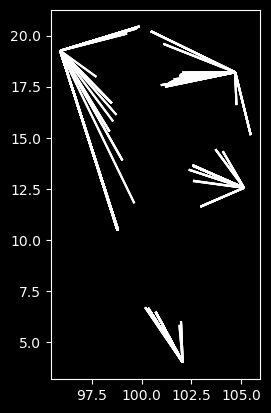

In [17]:
# find nodes which lie on far side of border crossing

border_crossing_mask = \
    (edges.from_iso_a3 != edges.to_iso_a3) \
    & ((edges.from_iso_a3 == study_country) | (edges.to_iso_a3 == study_country)) \
    & ((edges["mode"] == "road") | (edges["mode"] == "rail")) \
    
importing_node_ids = edges[border_crossing_mask].apply(find_importing_node_id, exporting_country=study_country, axis=1)
importing_nodes = nodes.set_index("id").loc[importing_node_ids].reset_index()
# two importing nodes are labelled as THA, drop these
importing_nodes = importing_nodes[importing_nodes.iso_a3 != study_country]

# connect these nodes to their containing country

land_border_to_importing_country_edges = \
    create_edges_to_destination_countries(importing_nodes, destination_country_nodes)
land_border_to_importing_country_edges.plot()

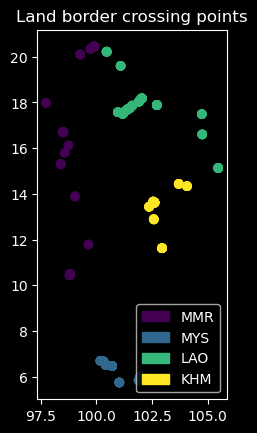

In [18]:
# plot THA land border crossing points for sanity

to_plot = importing_nodes
country_ints, labels = pd.factorize(to_plot["iso_a3"])
unique_country_ints = []
cmap = plt.get_cmap("viridis")
colours = [cmap(x) for x in country_ints / max(country_ints)]
[unique_country_ints.append(c) for c in colours if c not in unique_country_ints]
colour_map = dict(zip(labels, unique_country_ints))
f, ax = plt.subplots()
to_plot.plot(color=colours, ax=ax)
ax.set_title("Land border crossing points")
patches = [mpatches.Patch(color=colour, label=label) for label, colour in colour_map.items()]
ax.legend(handles=patches)

<Axes: >

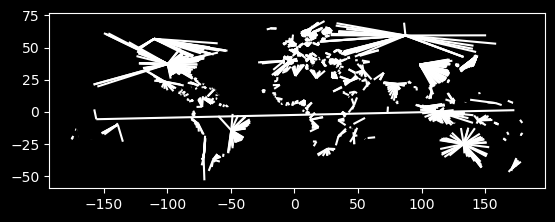

In [19]:
# connect foreign ports to their country with new edges

foreign_ports = maritime_nodes[maritime_nodes.infra=="port"]
foreign_ports = foreign_ports[foreign_ports.iso_a3 != study_country]
port_to_importing_countries_edges = create_edges_to_destination_countries(foreign_ports, destination_country_nodes)
port_to_importing_countries_edges.plot()

In [20]:
# now connect countries without a port (landlocked, typically), to their nearest (several) port(s)?

# ... turns out the only one of these seems to be Laos (LAO), but that's connected by land anyway

In [21]:
# add in edges connecting destination countries to THA land borders and foreign ports

edges = pd.concat(
    [
        edges.loc[:, edge_cols],
        duplicate_reverse_and_append_edges(land_border_to_importing_country_edges.loc[:, edge_cols]),
        duplicate_reverse_and_append_edges(port_to_importing_countries_edges.loc[:, edge_cols]),
    ]
).reset_index(drop=True)

# there are duplicate edges (repeated from_id -> to_id pairs), drop these here
edges["unique_edge_id"] = edges.apply(lambda row: f"{row.from_id}_{row.to_id}", axis=1)
edges = edges[~edges.unique_edge_id.duplicated(keep="first")].drop(columns=["unique_edge_id"])

In [23]:
# write out global multi-modal transport network to disk

save_dir = os.path.join(root_dir, "results/multi-modal_network/")
os.makedirs(save_dir, exist_ok=True)

# reset indicies to 0-start integers
# these will correspond to igraph's internal edge/vertex ids
nodes = nodes.reset_index(drop=True)
nodes.to_parquet(os.path.join(save_dir, "nodes.gpq"))
edges = edges.reset_index(drop=True)
edges.to_parquet(os.path.join(save_dir, "edges.gpq"))